In [3]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)

import wfsc_tests as wfsc
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

from wfsc_tests.math_module import xp, _scipy, ensure_np_array

import cgi_phasec_poppy

# iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
iefc_dir = Path('/home/kianmilani/Projects/roman-cgi-iefc-data')

dm1_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

[38707575.47272583 39321120.8208112  39547077.1074424  39943806.87193675
 39965070.57571509] ph / (s m2)


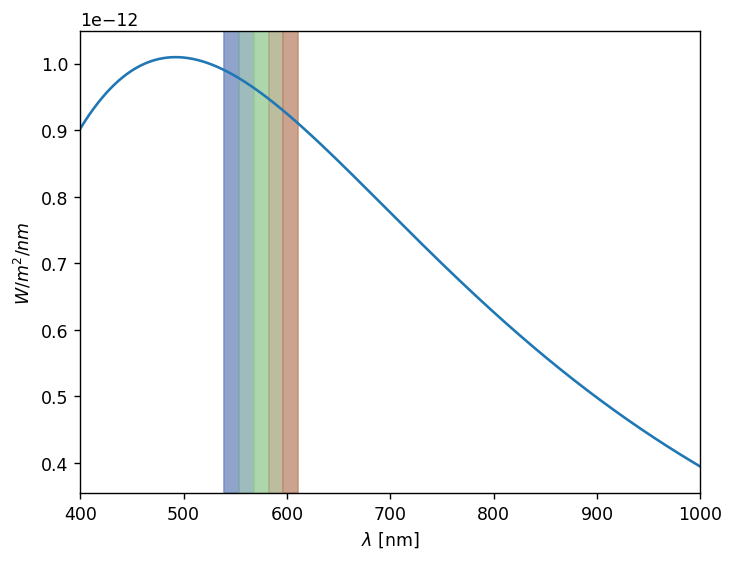

In [4]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 575e-9*u.m

nlam = 5
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

from astropy.constants import h, c, k_B, R_sun

uma47 = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=5887*u.K,
                                            distance=14.06*u.parsec,
                                            diameter=2*1.172*R_sun)

uma47.plot_spectrum()

source_fluxes = uma47.calc_fluxes()
print(source_fluxes)

In [5]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

wavelength_c = 575e-9*u.m

kwargs = {
    'cgi_mode':'hlc',
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':10,
}

actors = []
for i in range(nlam):
    actors.append(rayCGI.options(num_gpus=1/nlam).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

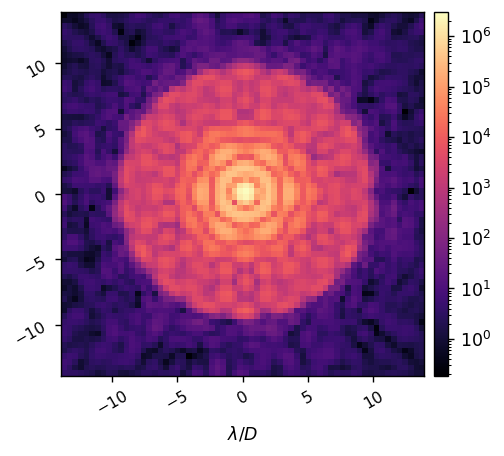

2981884.6766394516

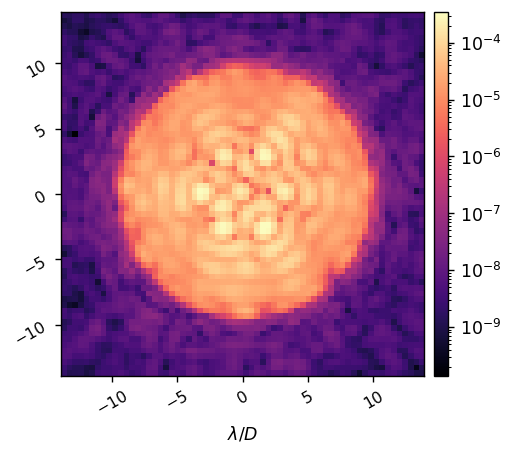

In [6]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.set_dm1(dm1_flat)
mode.set_dm2(dm2_flat)

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
wfsc.imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Iref = max_ref
ref_im = mode.snap()
wfsc.imshow1(ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

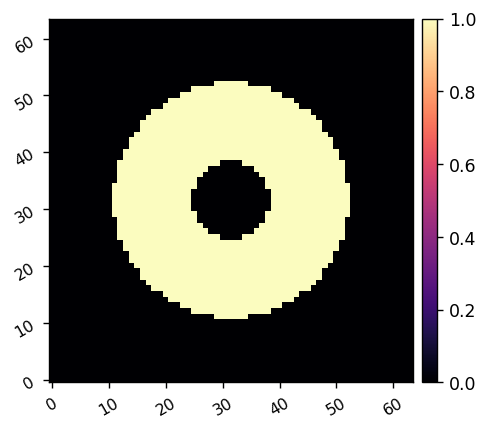

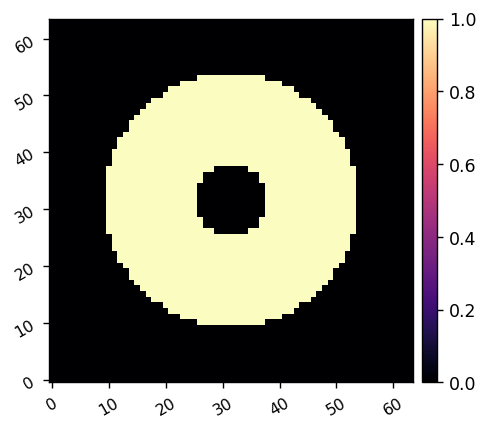

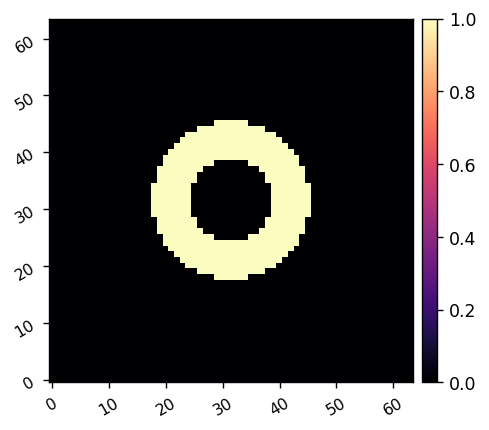

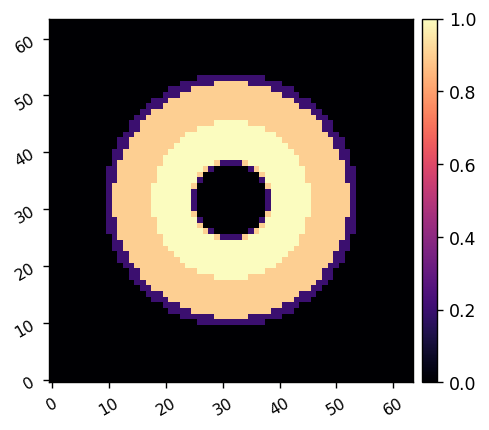

In [9]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (xp.linspace(-mode.npsf/2, mode.npsf/2-1, mode.npsf) + 1/2)*mode.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
#         'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
#         'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 3.2
owa = 6
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
#         'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi3 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.2
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

# Create probe and fourier modes

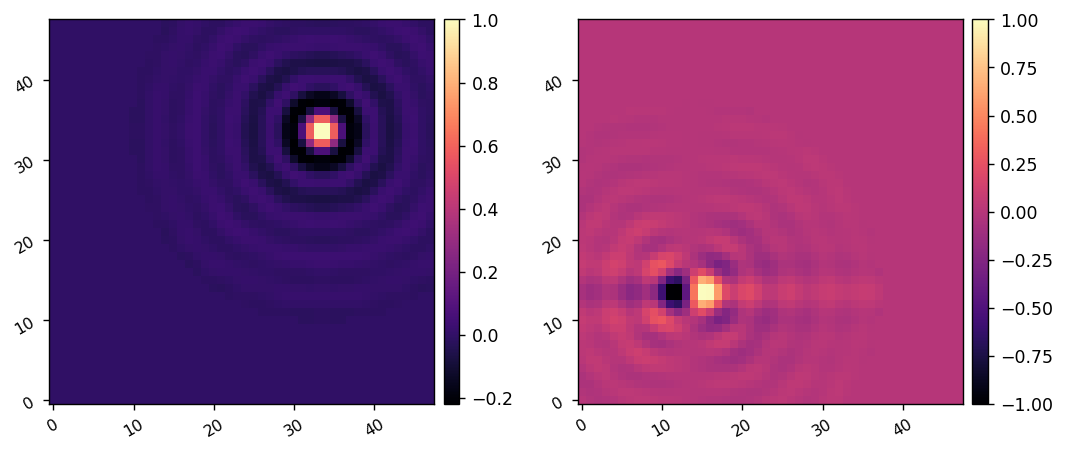

In [10]:
reload(wfsc.utils)
probe_amp = 2.5e-8
fourier_modes, fs = wfsc.utils.select_fourier_modes(mode, control_mask*(fpx>0), fourier_sampling=0.5) 
probe_modes = wfsc.utils.create_fourier_probes(fourier_modes, shift_cos=(10,10), shift_sin=(-10,-10), plot=True)

In [11]:
Nacts = int(mode.dm_mask.sum())

calib_amp = 2.5e-9

calib_modes = xp.zeros((Nacts, mode.Nact, mode.Nact))
count=0
for i in range(mode.Nact):
    for j in range(mode.Nact):
        if mode.dm_mask[i,j]:
            calib_modes[count, i,j] = 1
            count+=1
            
calib_modes = calib_modes[:,:].reshape(Nacts, mode.Nact**2)

# import time
# for i in range(Nacts):
#     try:
#         wfsc.imshow1(calib_modes[i].reshape(Nact,Nact))
#         clear_output(wait=True)
#         time.sleep(0.25)
#     except KeyboardInterrupt:
#         break

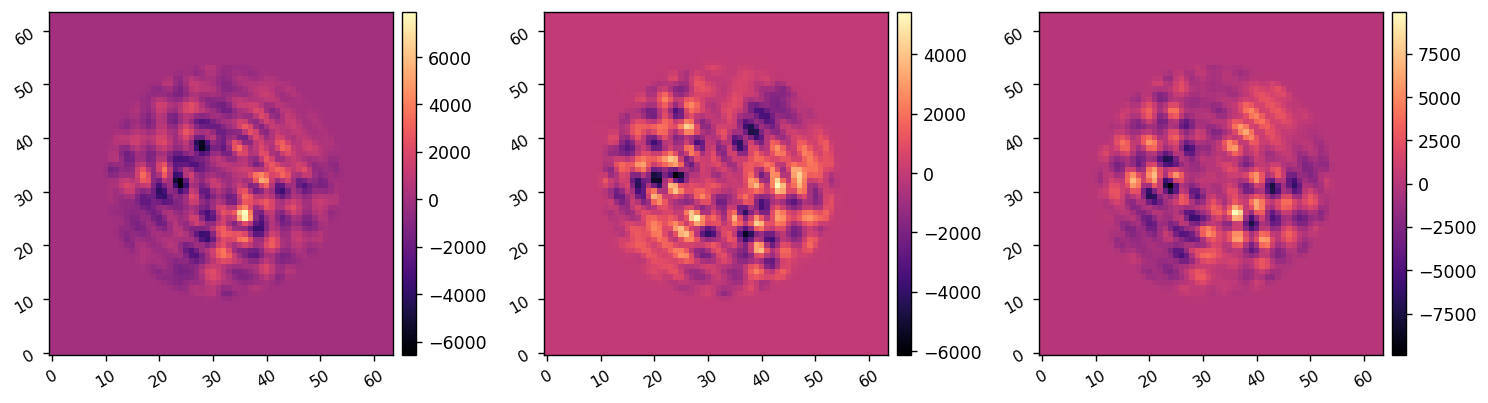

In [12]:
reload(wfsc.iefc)

mode.set_dm1(dm1_flat)
mode.set_dm2(dm2_flat)

differential_images, single_images = wfsc.iefc_2dm.take_measurement(mode, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

In [10]:
reload(wfsc.iefc_2dm)

response_matrix, response_cube = wfsc.iefc_2dm.calibrate(mode, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, ensure_np_array(calib_modes), 
                                                         return_all=True)


Calibrating iEFC...


KeyboardInterrupt: 

In [15]:
# date = 20230629
date = 20230707
response_matrix = xp.array(fits.getdata(iefc_dir/'response-data'/f'hlcbb_iefc_2dm_poke_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(iefc_dir/'response-data'/f'hlcbb_iefc_2dm_poke_response_cube_{date}.fits'))

In [16]:
response_cube.shape

(3560, 2, 4096)

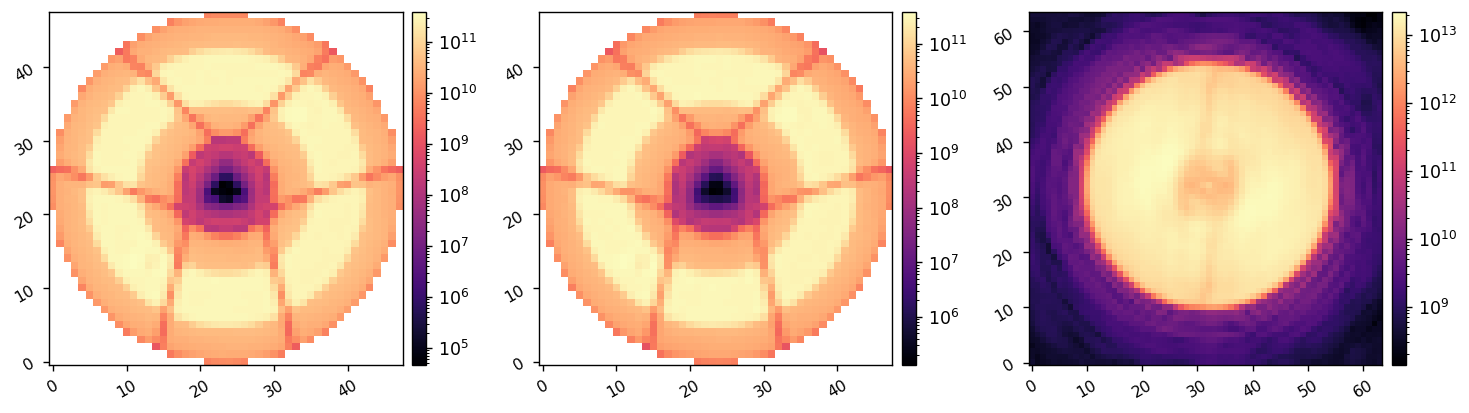

In [19]:
reload(wfsc.utils)
dm1_response = wfsc.utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_cube)**2, axis=(1,2)))[::2], mode.dm_mask)
dm2_response = wfsc.utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_cube)**2, axis=(1,2)))[1::2], mode.dm_mask)
fp_response = xp.sum(abs(response_cube), axis=(0,1)).reshape(mode.npsf, mode.npsf)

wfsc.imshow3(dm1_response , dm2_response, fp_response, lognorm=True)

# Run IEFC

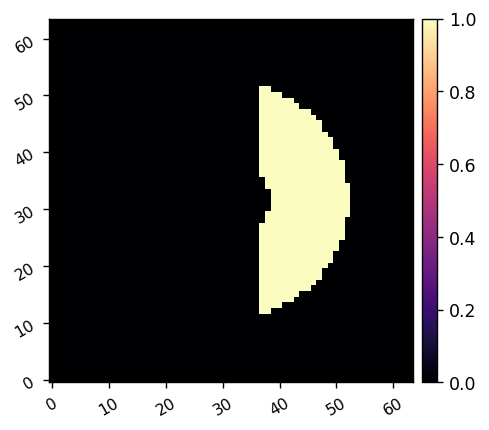

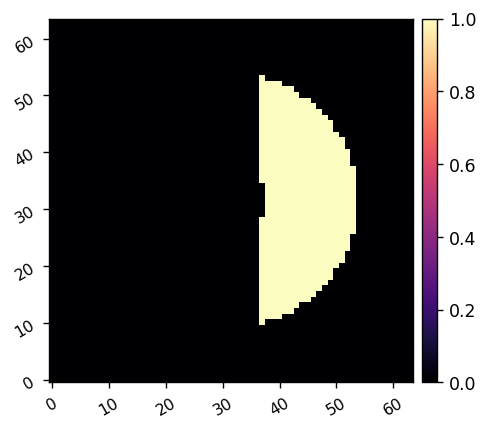

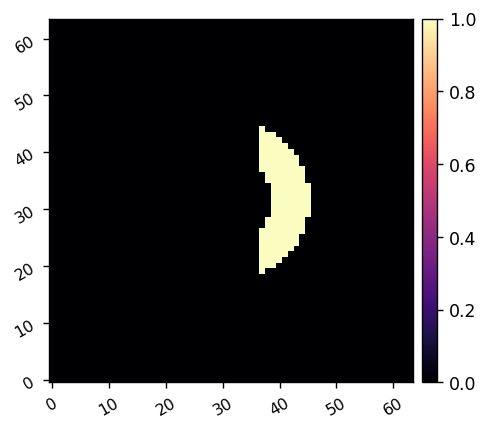

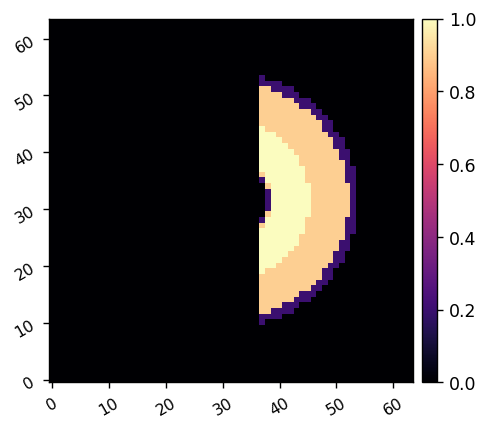

In [21]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (xp.linspace(-mode.npsf/2, mode.npsf/2-1, mode.npsf) + 1/2)*mode.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 3.2
owa = 6
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi3 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.2
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

In [34]:
calib_modes.shape

(1780, 2304)

In [22]:
response_cube_corrected = xp.concatenate((response_cube[::2], response_cube[1::2]))
response_matrix_full = response_cube_corrected[:,:,control_mask.ravel()].reshape(3560, -1).T
response_matrix_full.shape

(1108, 3560)

In [32]:
control_mask.sum()

array(554)

(1108, 1108) (1108, 3560)
Running I-EFC...
	Closed-loop iteration 1 / 30


(3560,)

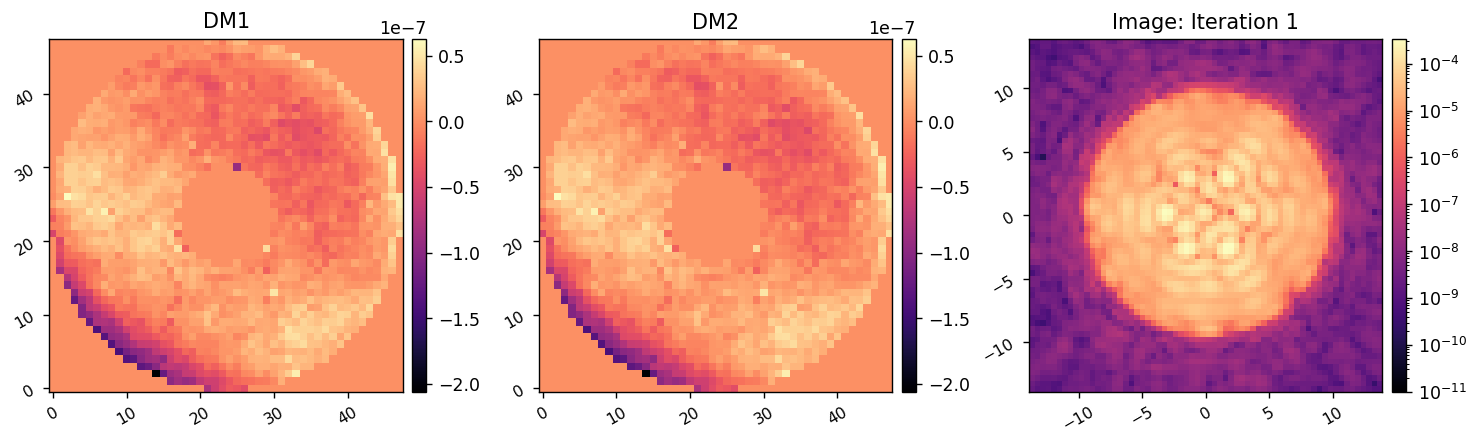

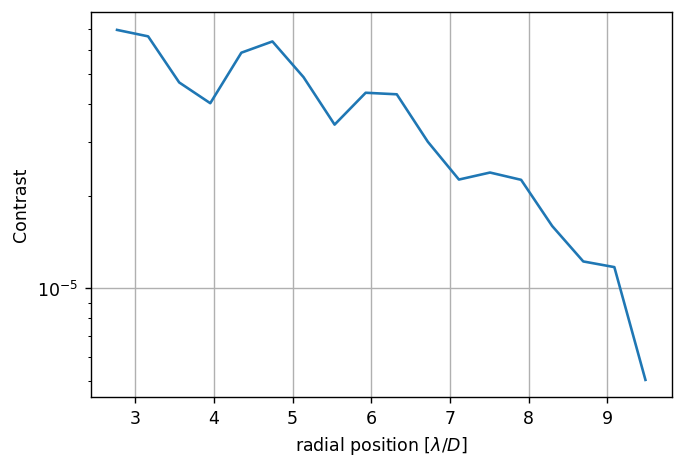

	Closed-loop iteration 2 / 30


(3560,)

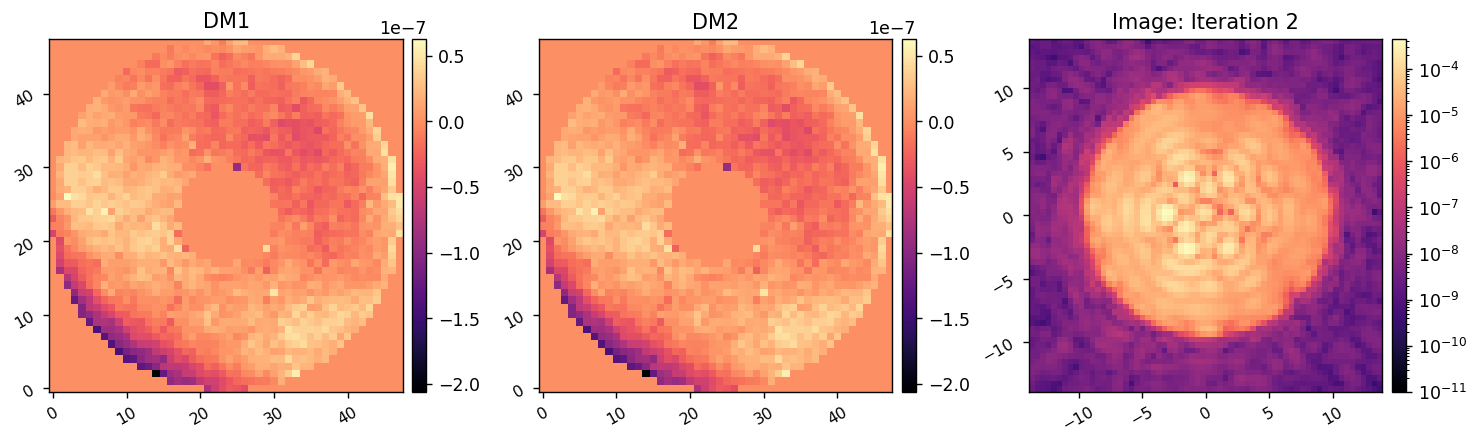

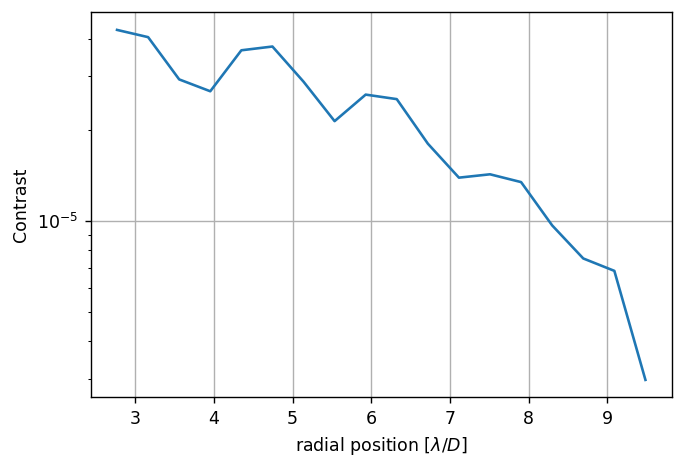

	Closed-loop iteration 3 / 30


(3560,)

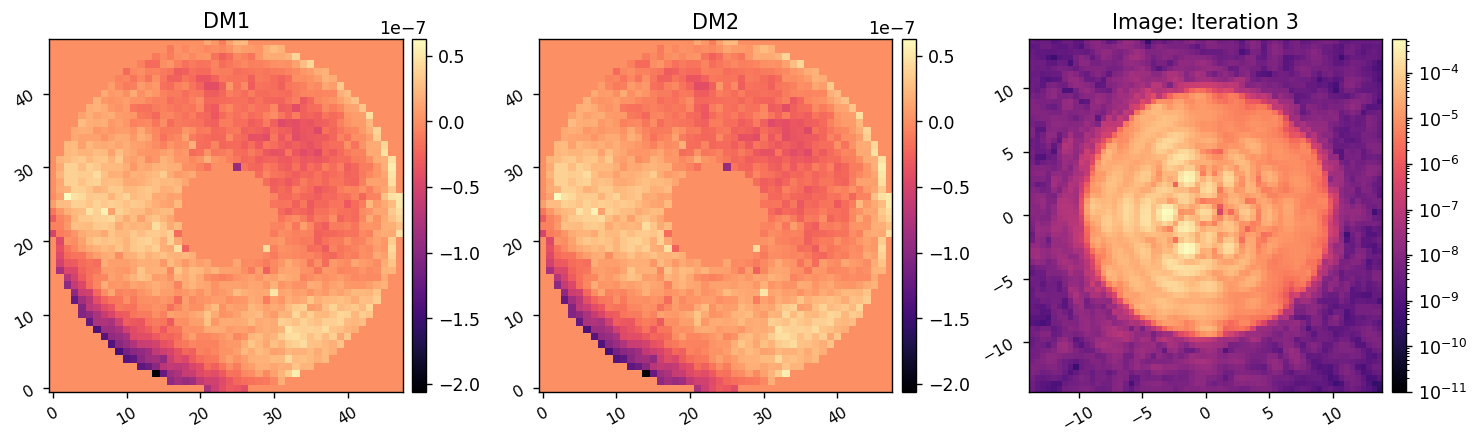

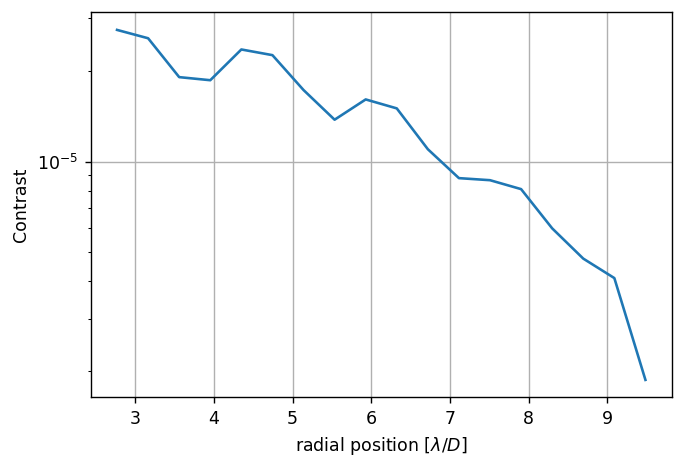

	Closed-loop iteration 4 / 30


(3560,)

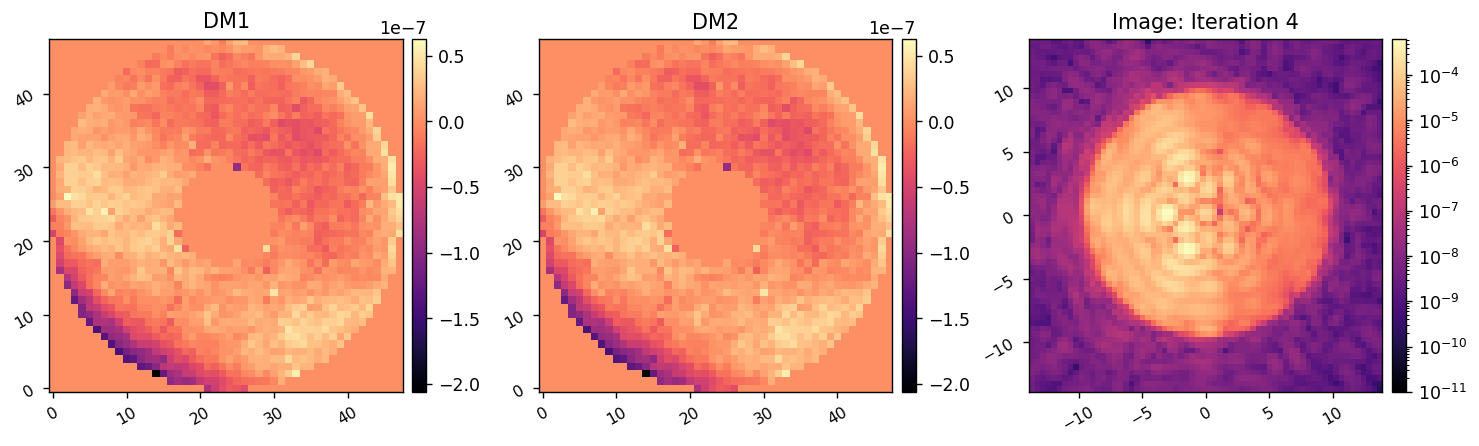

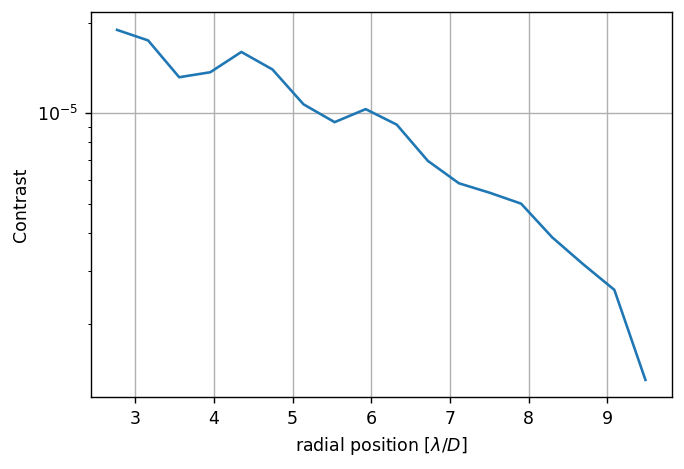

	Closed-loop iteration 5 / 30


(3560,)

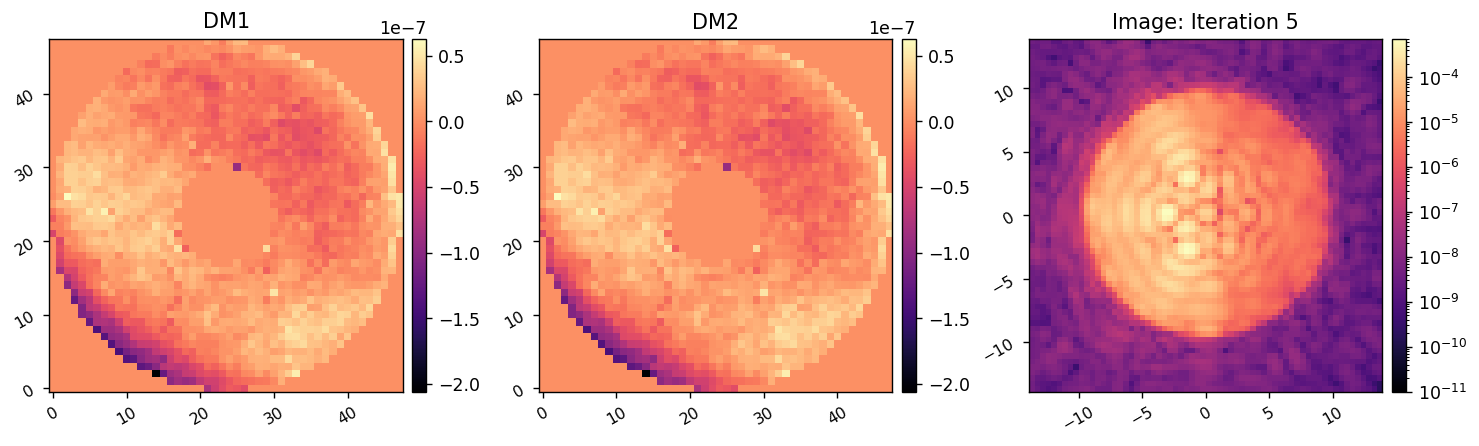

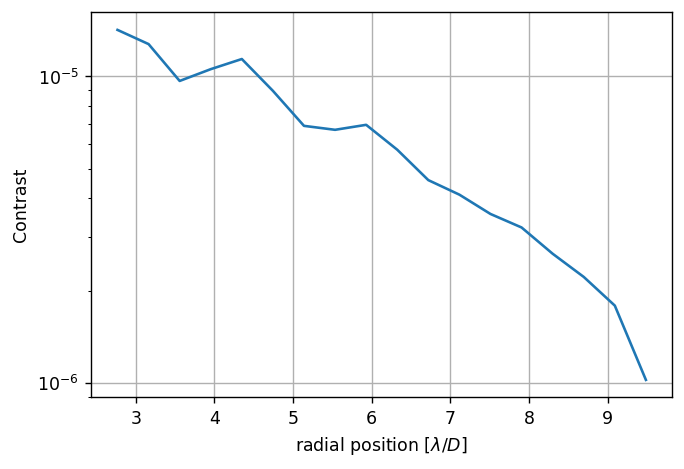

	Closed-loop iteration 6 / 30


(3560,)

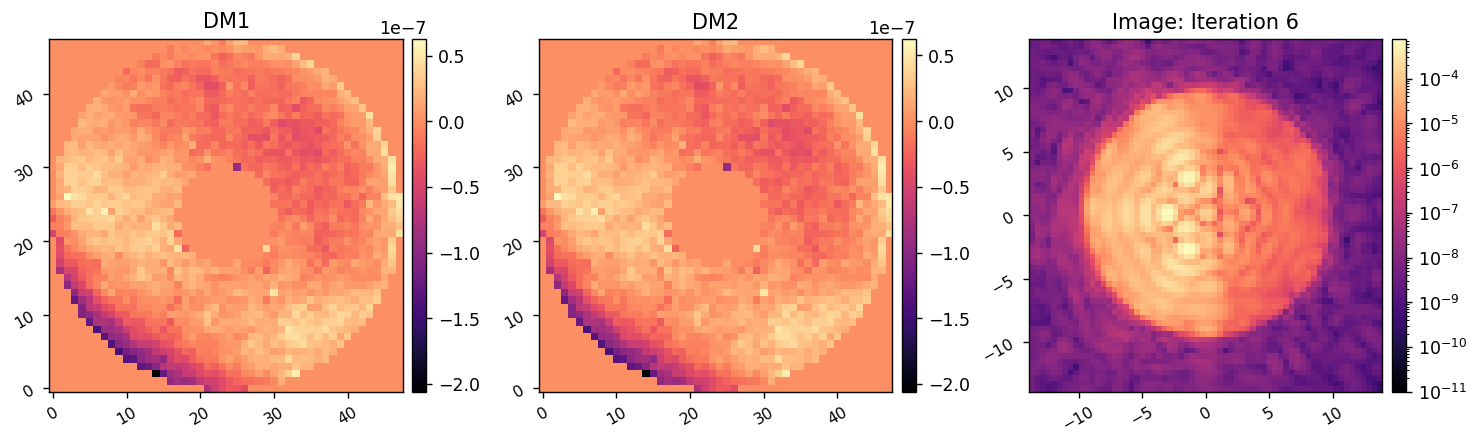

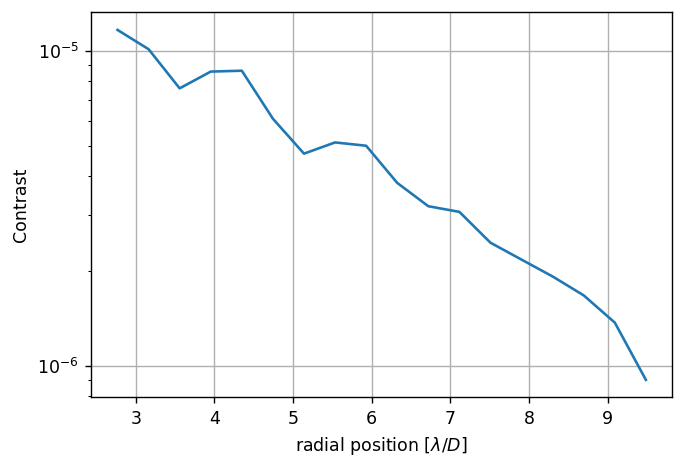

	Closed-loop iteration 7 / 30


(3560,)

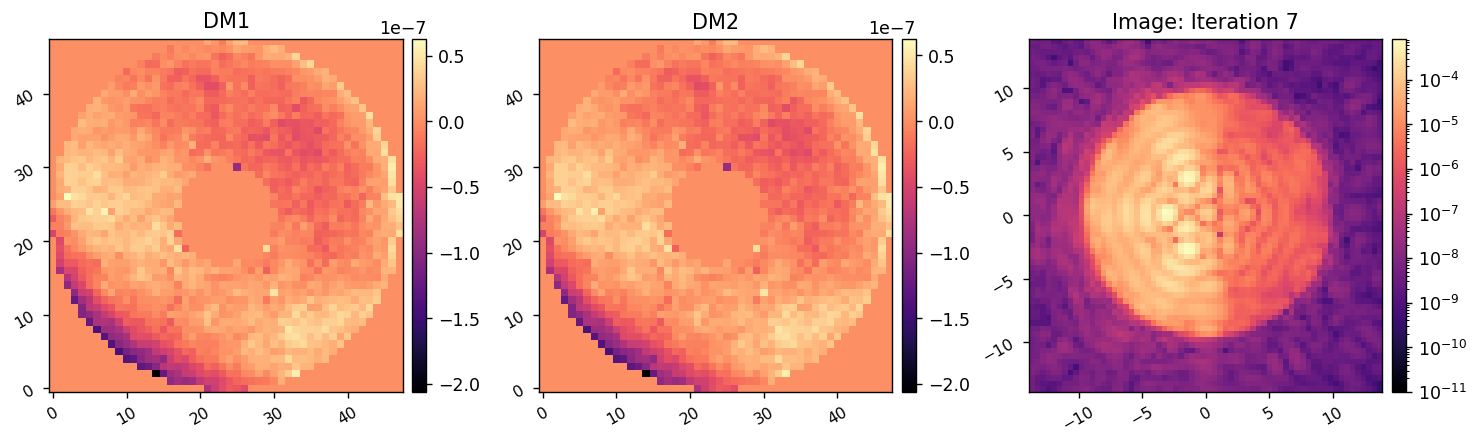

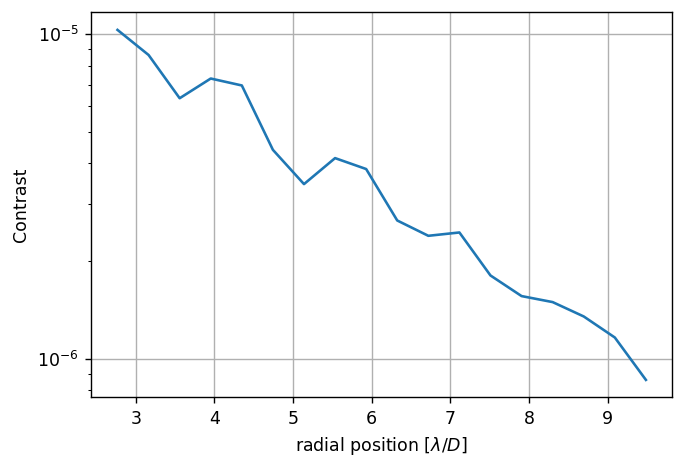

	Closed-loop iteration 8 / 30


(3560,)

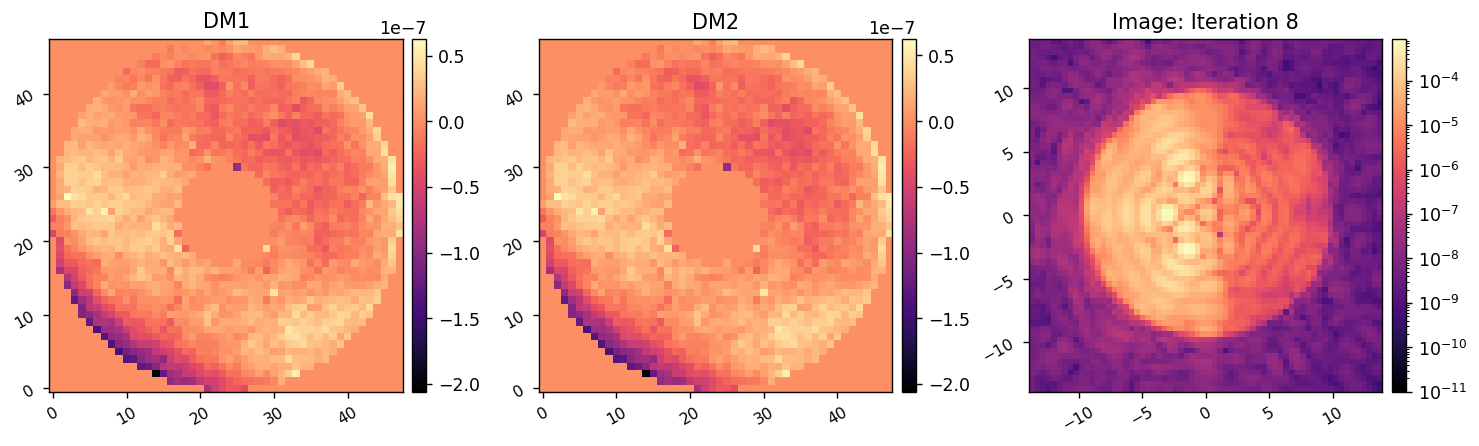

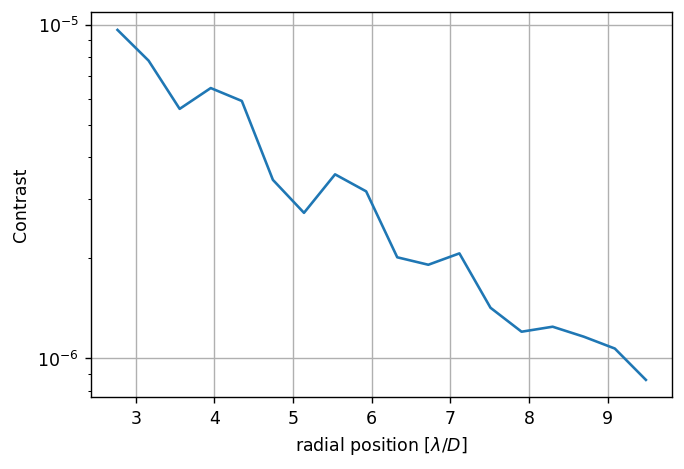

	Closed-loop iteration 9 / 30


(3560,)

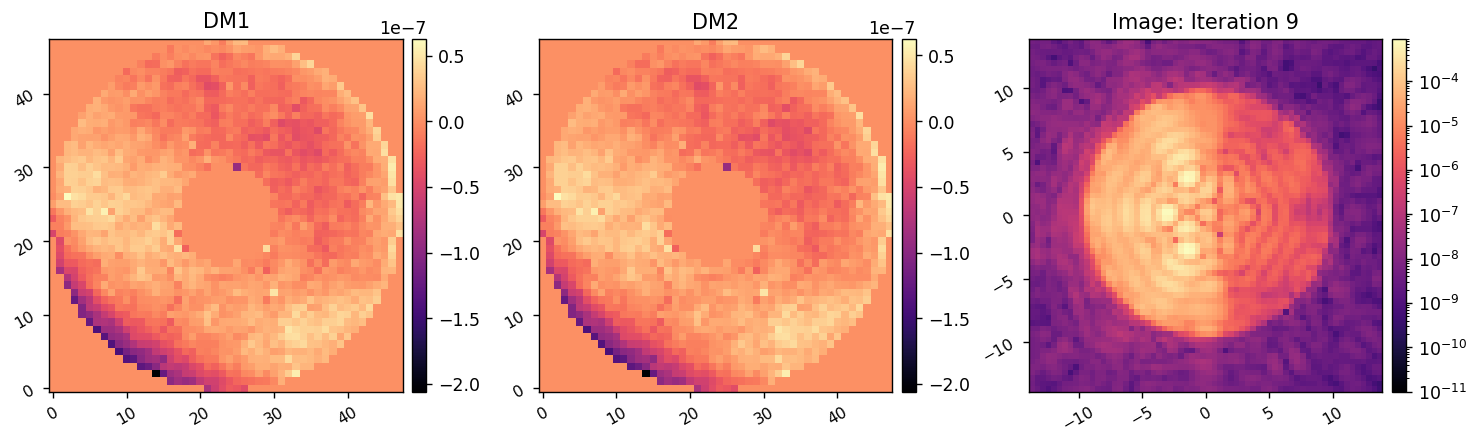

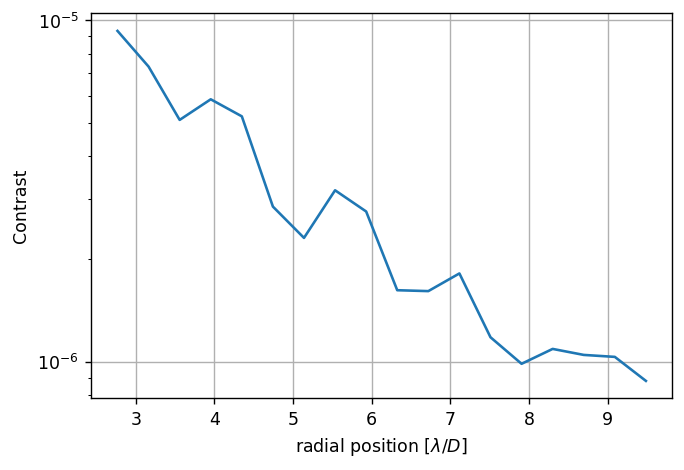

	Closed-loop iteration 10 / 30


(3560,)

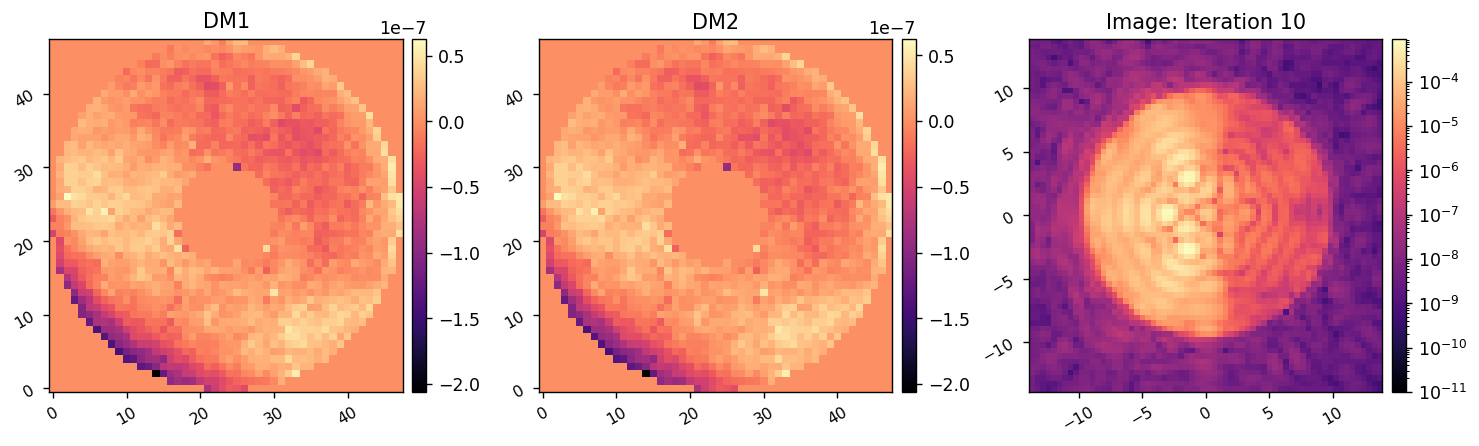

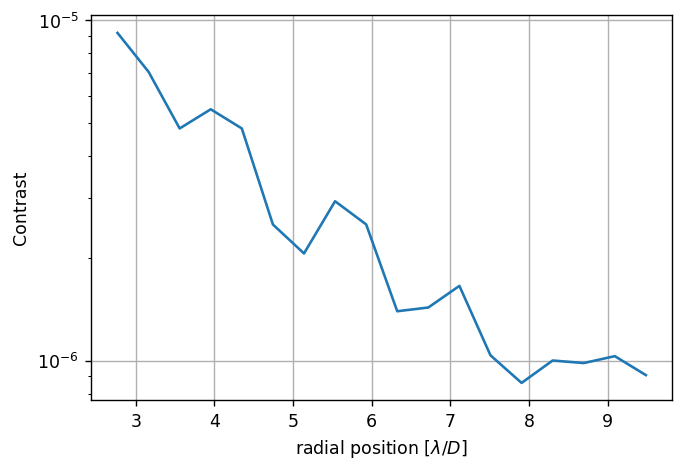

	Closed-loop iteration 11 / 30


(3560,)

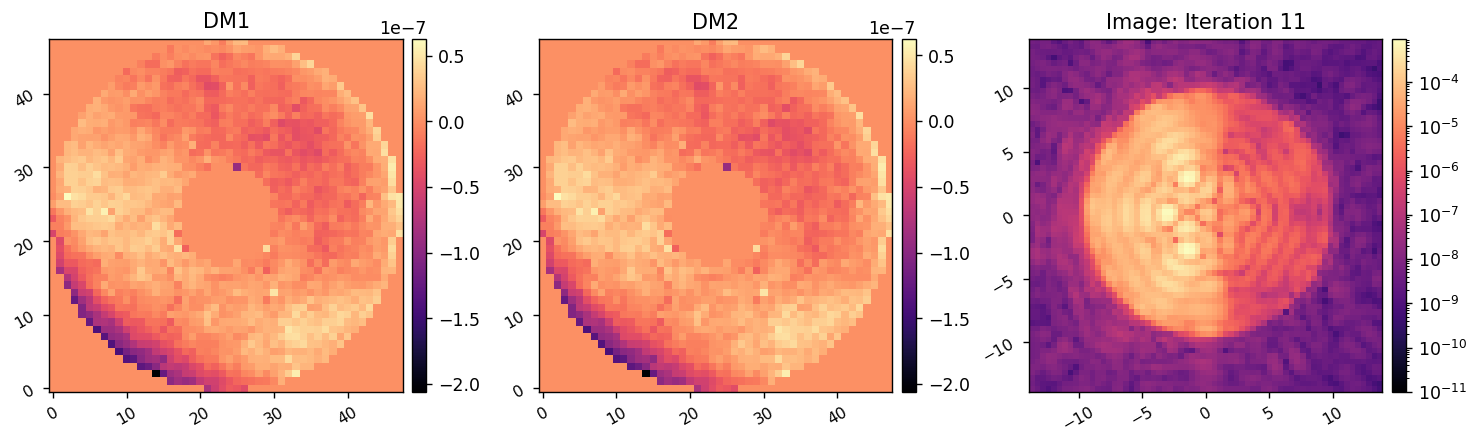

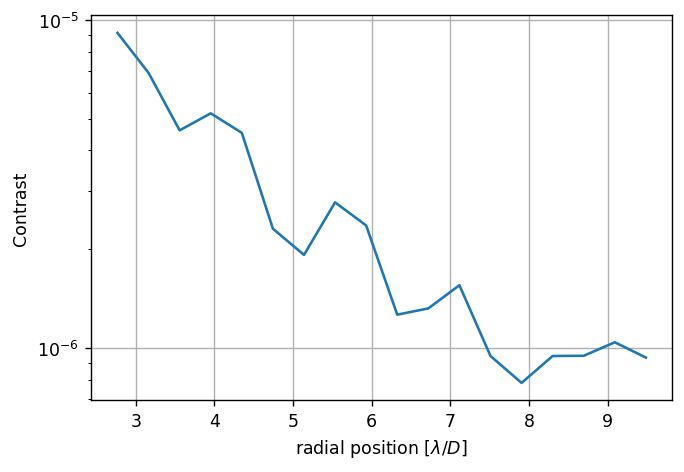

	Closed-loop iteration 12 / 30


(3560,)

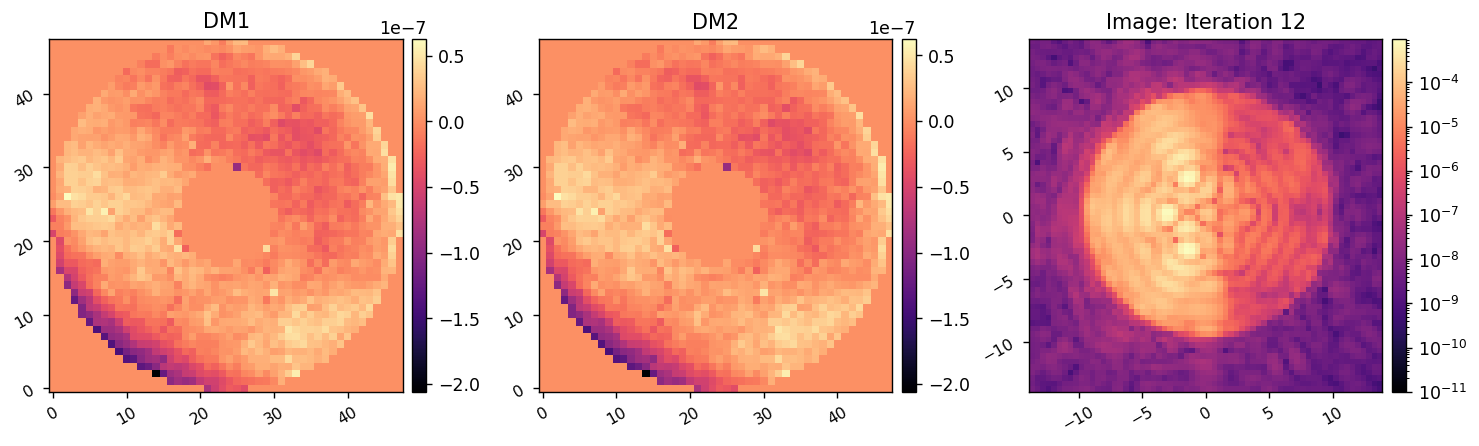

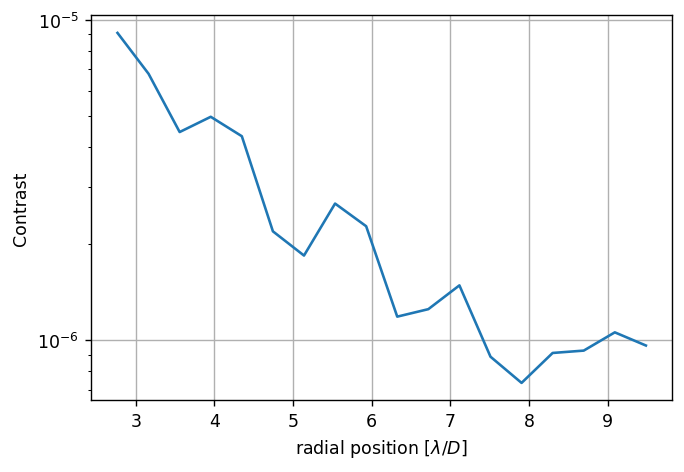

	Closed-loop iteration 13 / 30


(3560,)

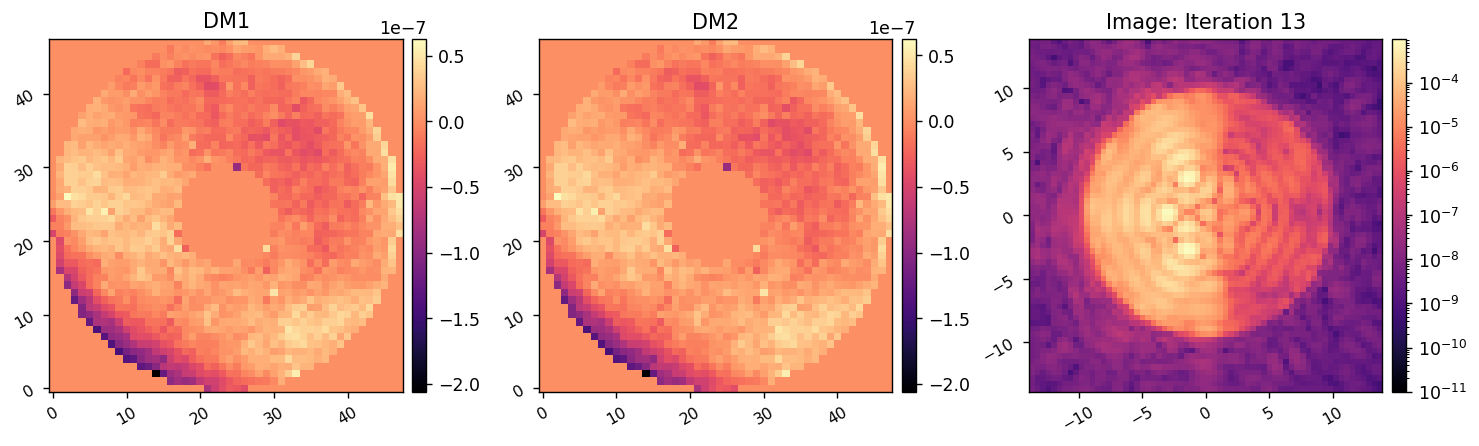

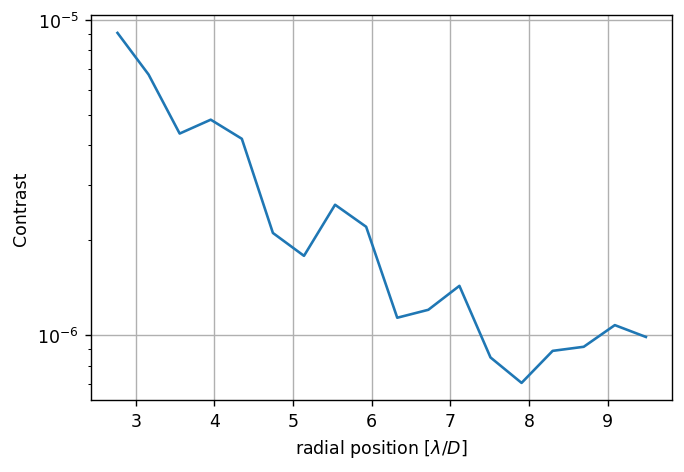

	Closed-loop iteration 14 / 30


(3560,)

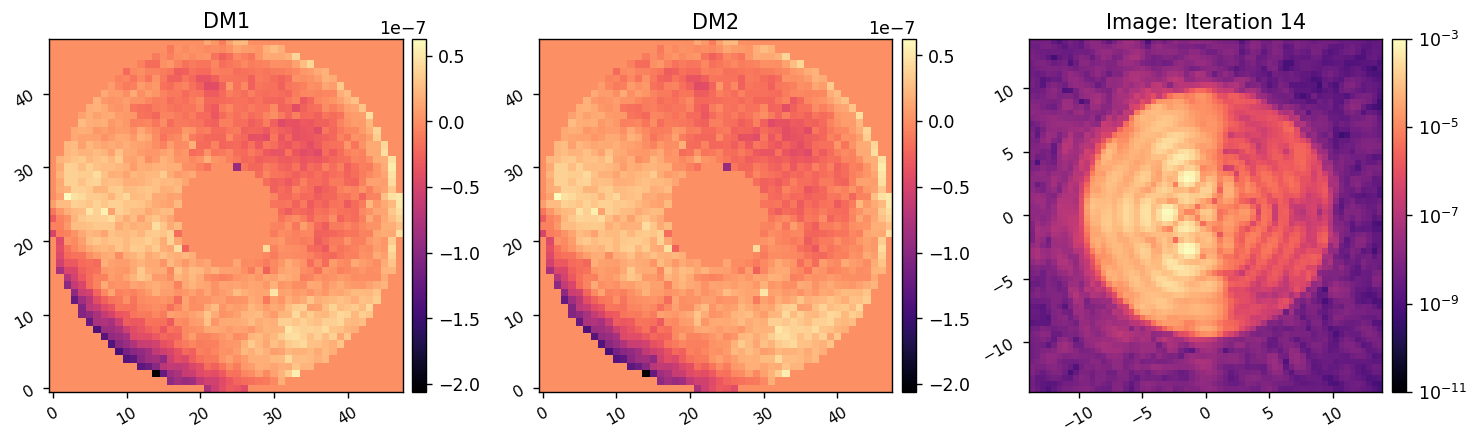

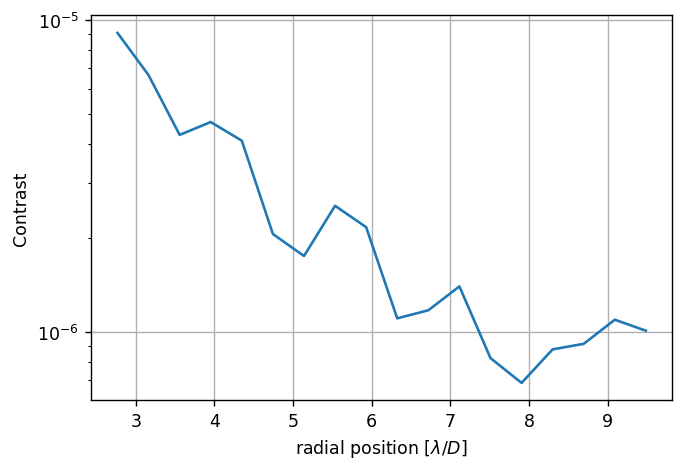

	Closed-loop iteration 15 / 30


(3560,)

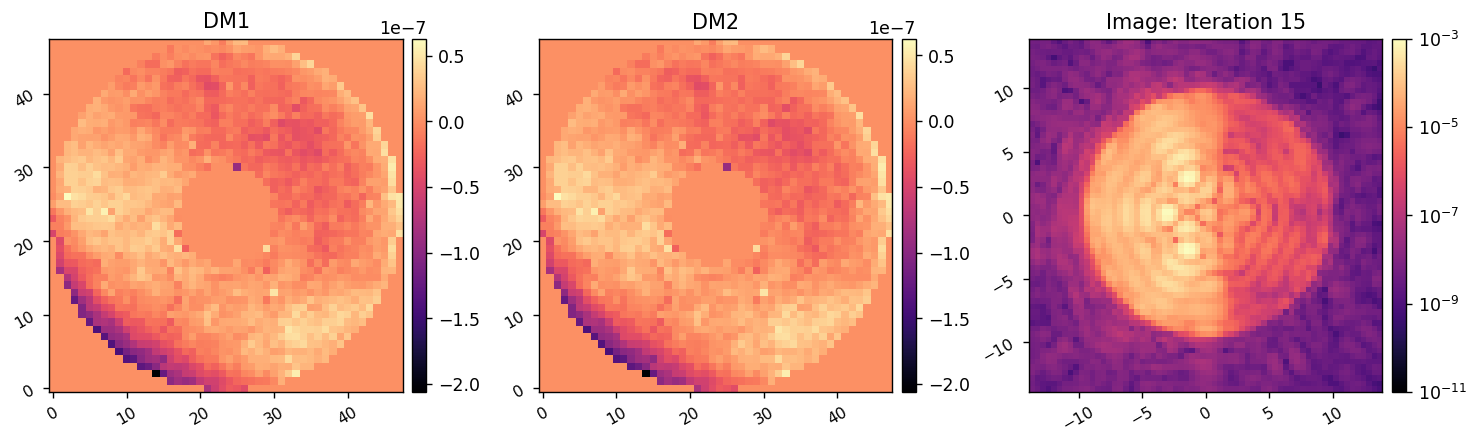

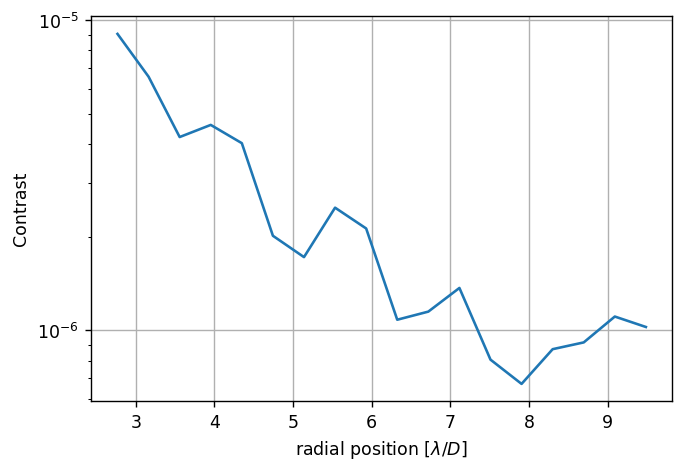

	Closed-loop iteration 16 / 30


(3560,)

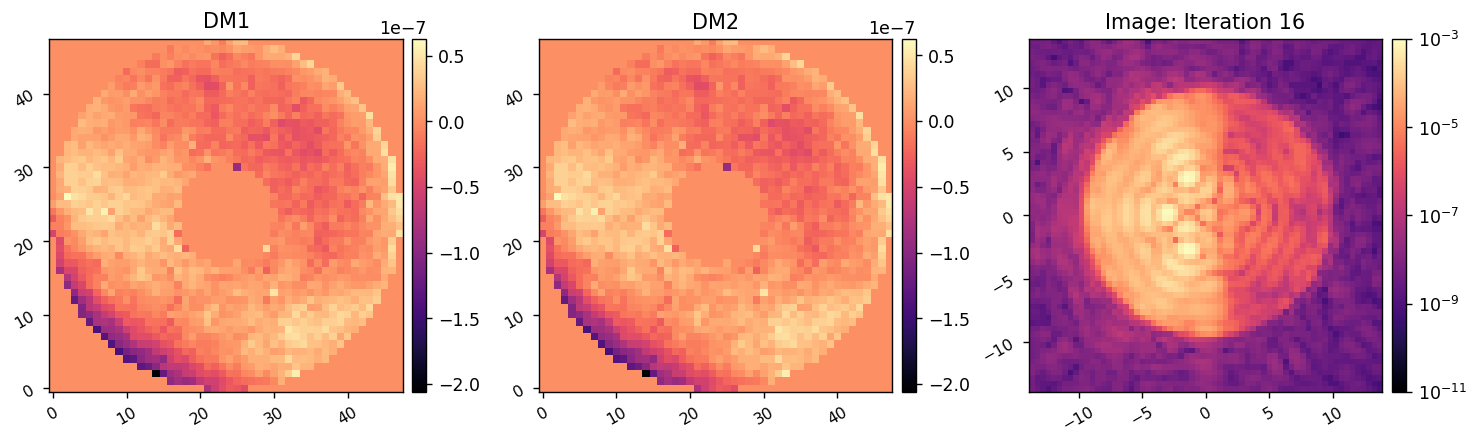

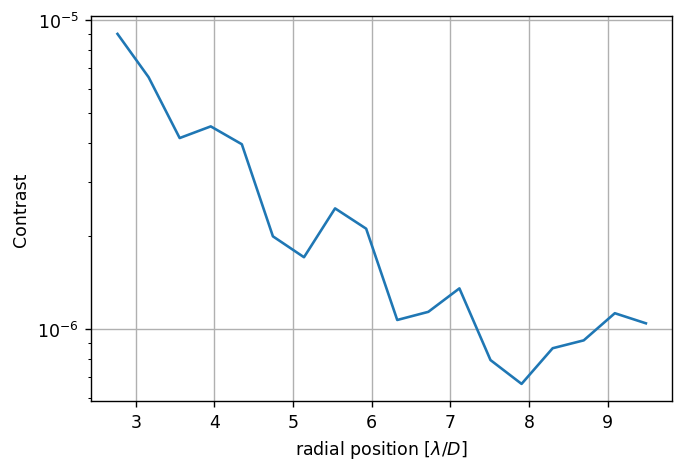

	Closed-loop iteration 17 / 30


(3560,)

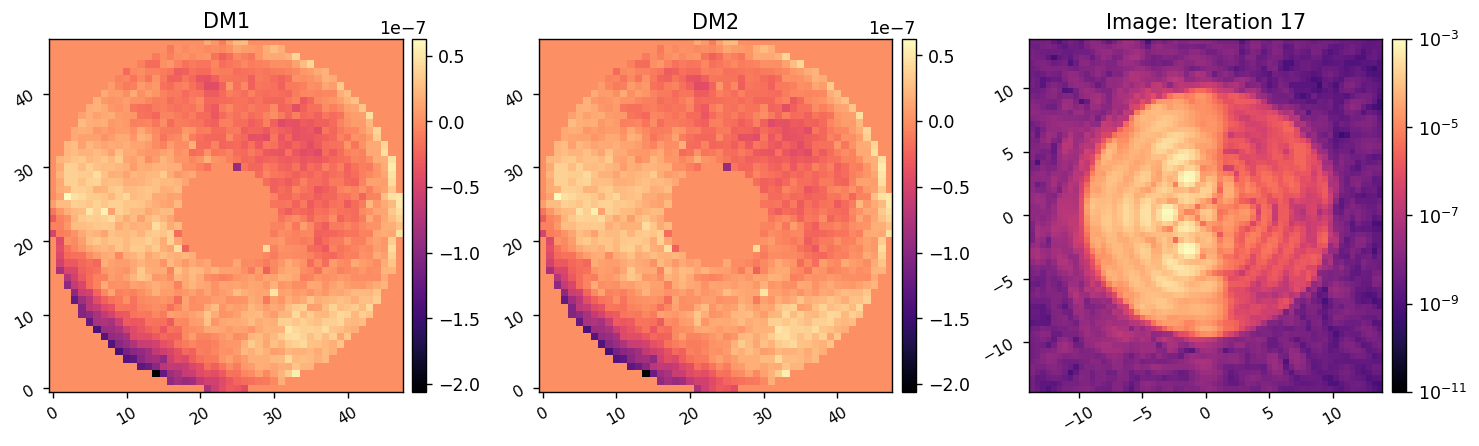

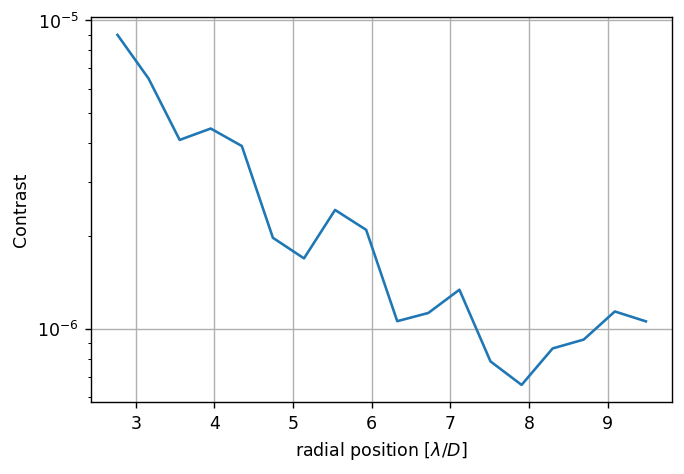

	Closed-loop iteration 18 / 30


(3560,)

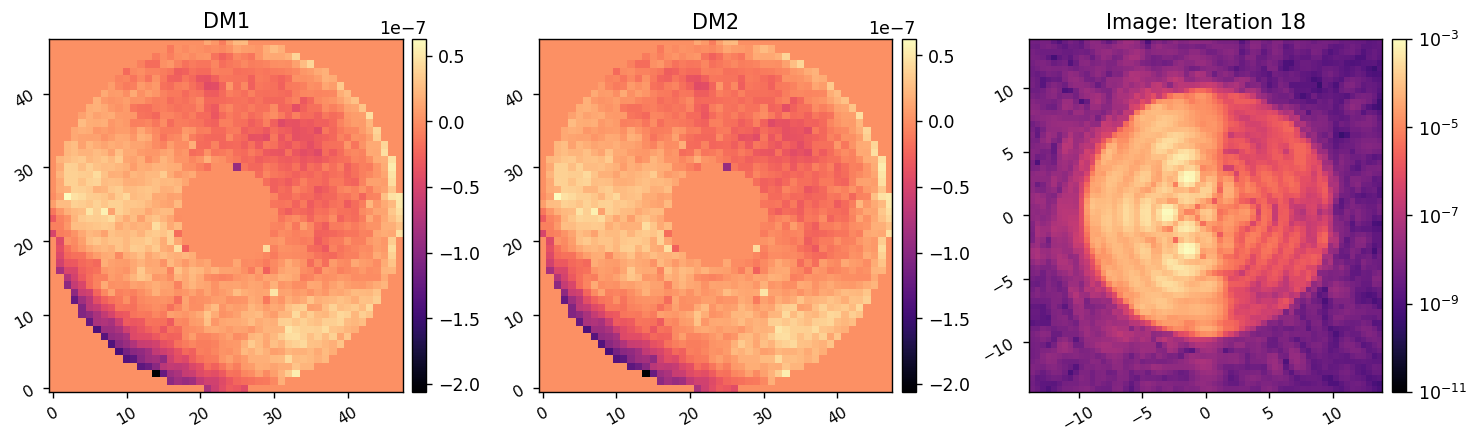

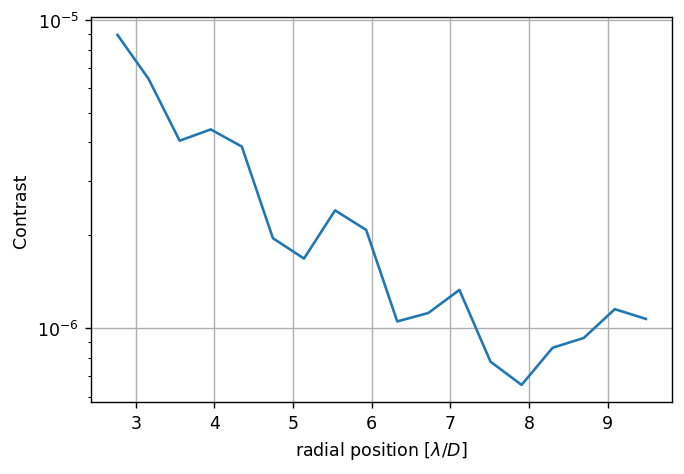

	Closed-loop iteration 19 / 30


(3560,)

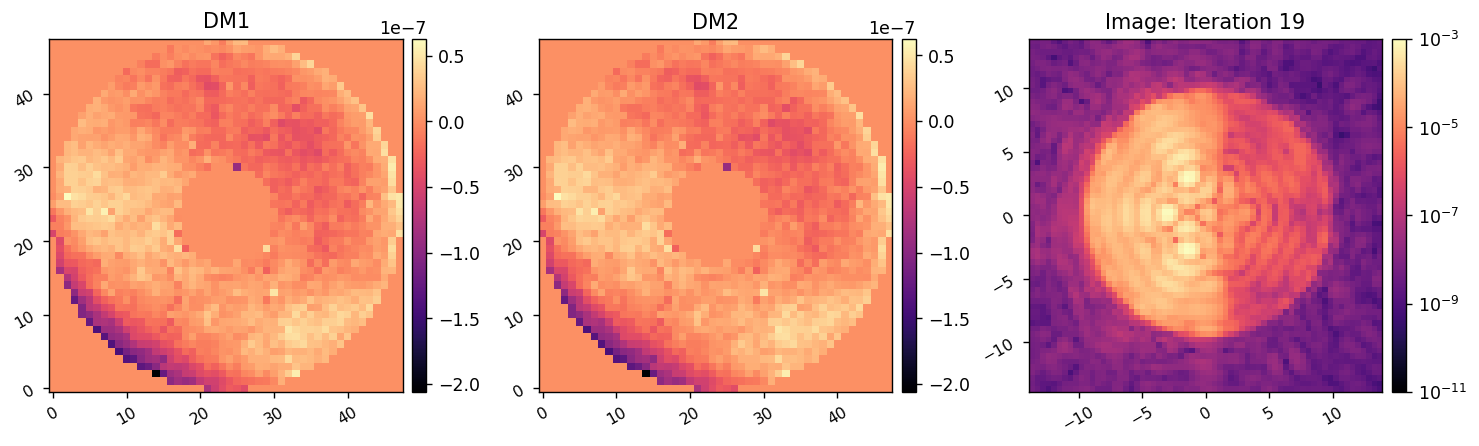

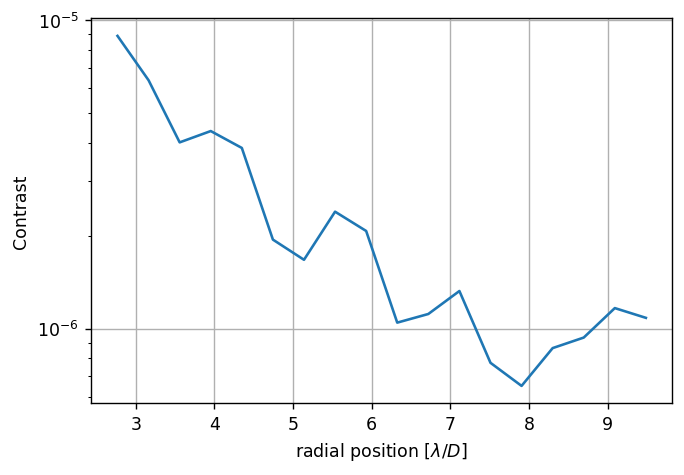

	Closed-loop iteration 20 / 30


(3560,)

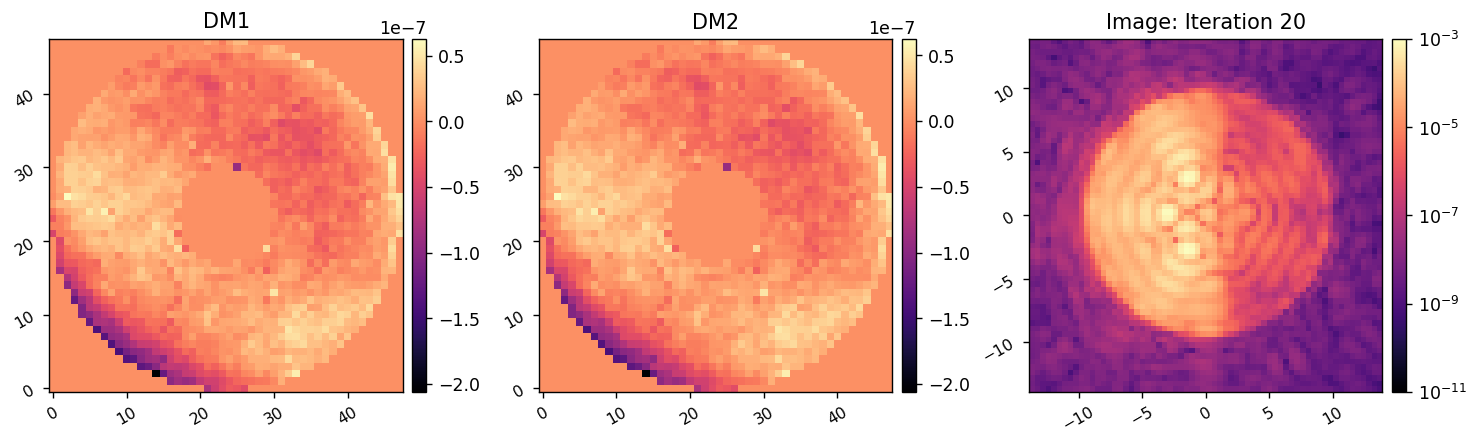

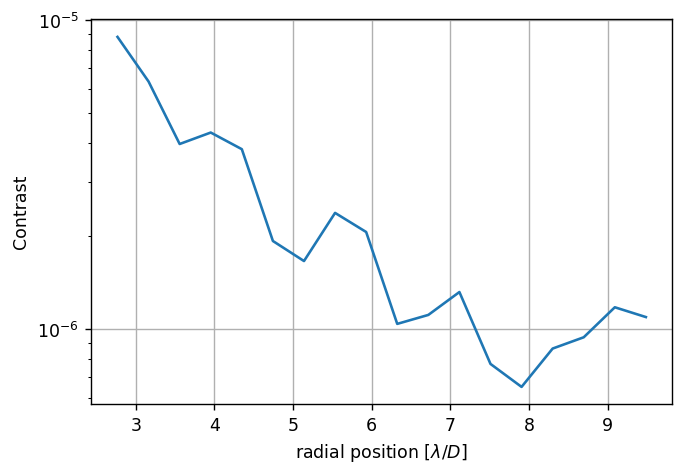

	Closed-loop iteration 21 / 30


KeyboardInterrupt: 

In [31]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

mode.set_dm1(dm1_flat)
mode.set_dm2(dm2_flat)

reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_full, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(mode, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=30, 
                                          loop_gain=0.25, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

(1108, 1108) (1108, 3560)
Running I-EFC...
	Closed-loop iteration 1 / 5


(3560,)

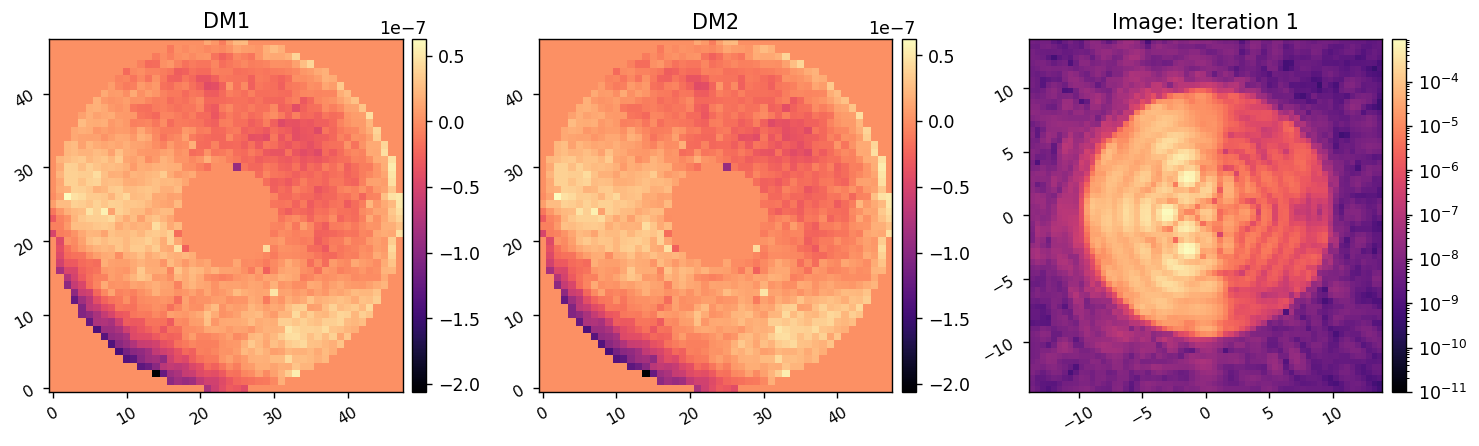

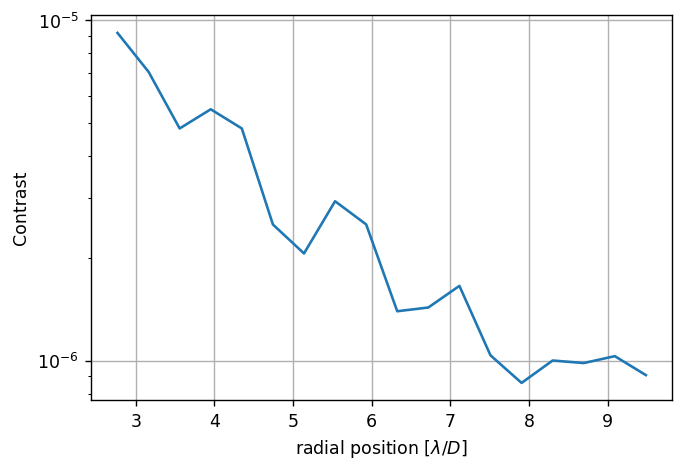

	Closed-loop iteration 2 / 5


(3560,)

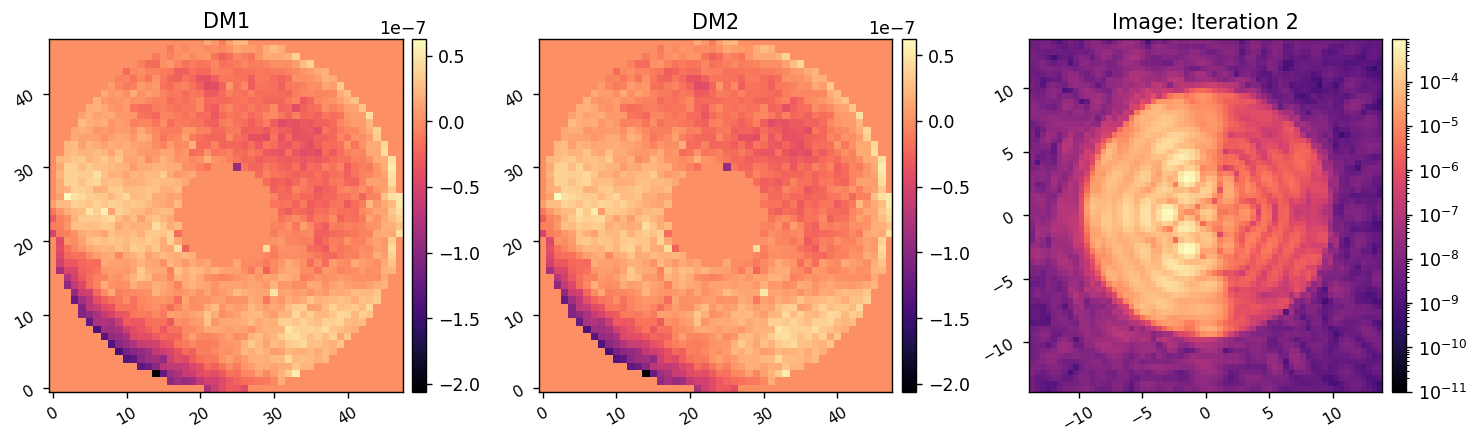

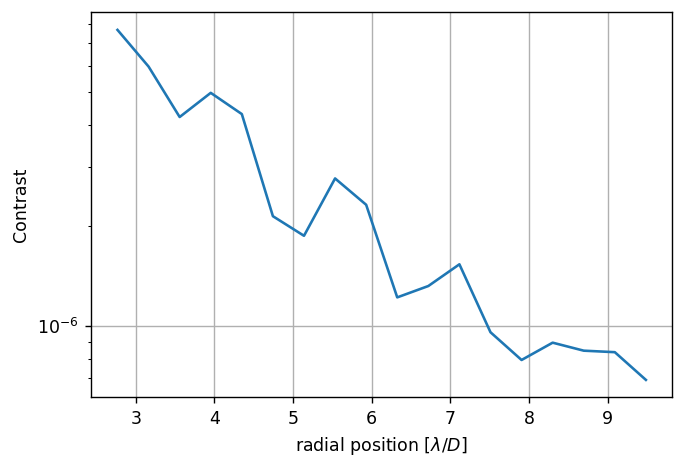

	Closed-loop iteration 3 / 5


(3560,)

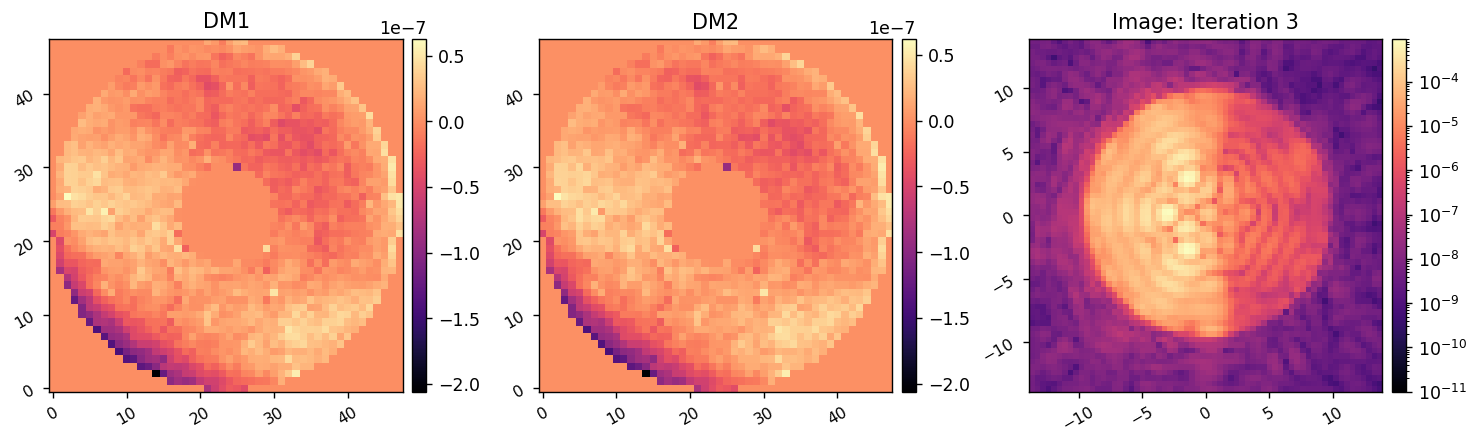

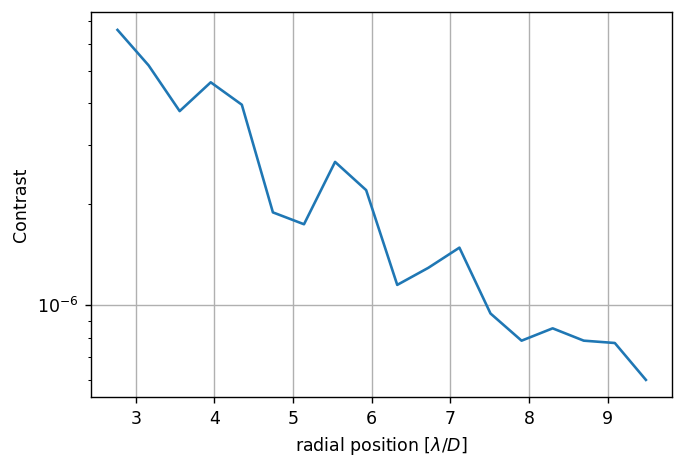

	Closed-loop iteration 4 / 5


(3560,)

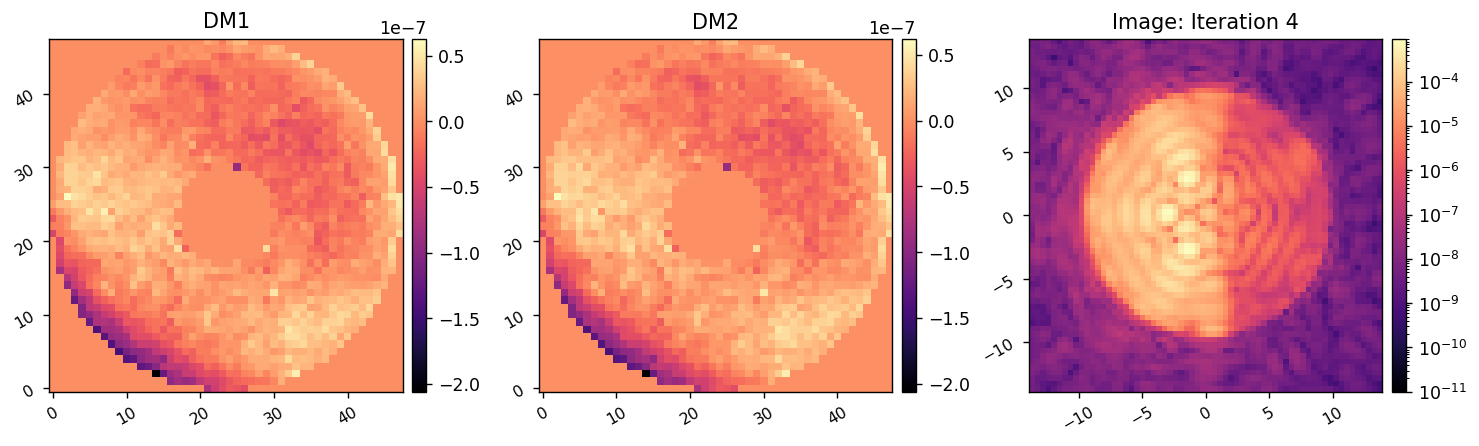

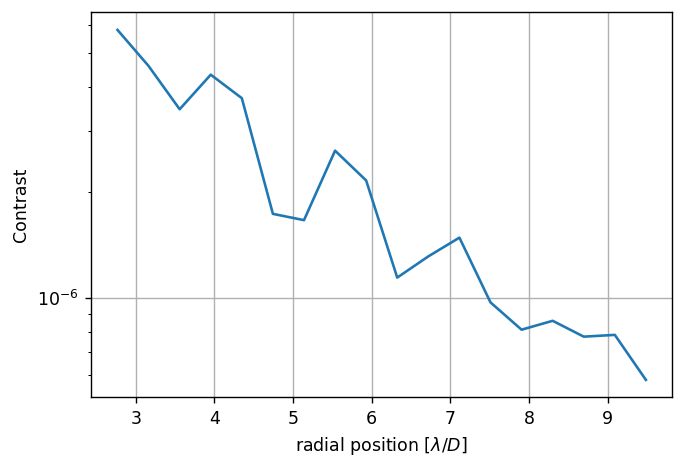

	Closed-loop iteration 5 / 5


(3560,)

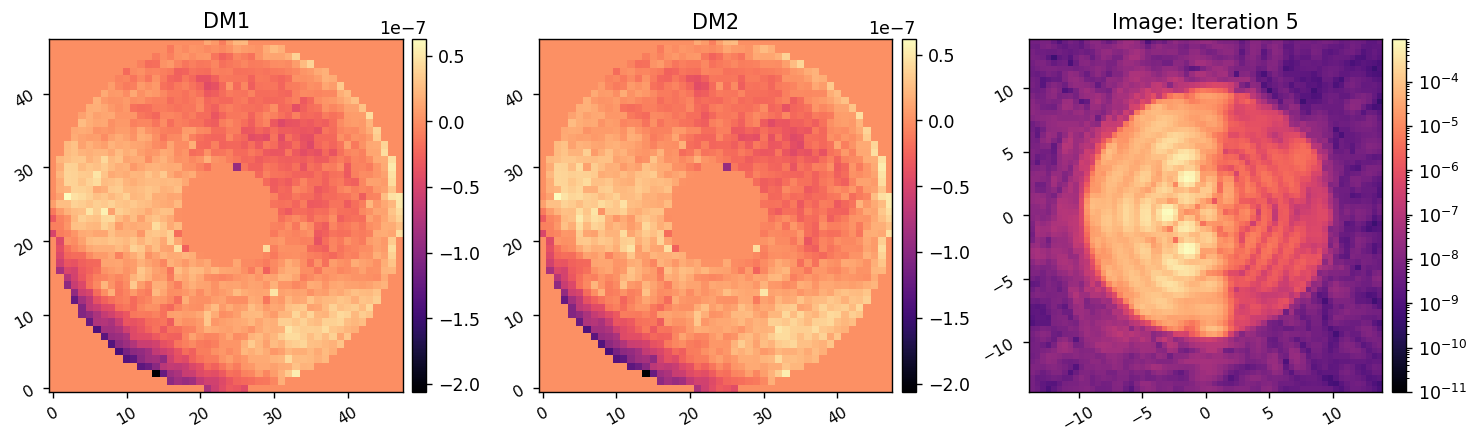

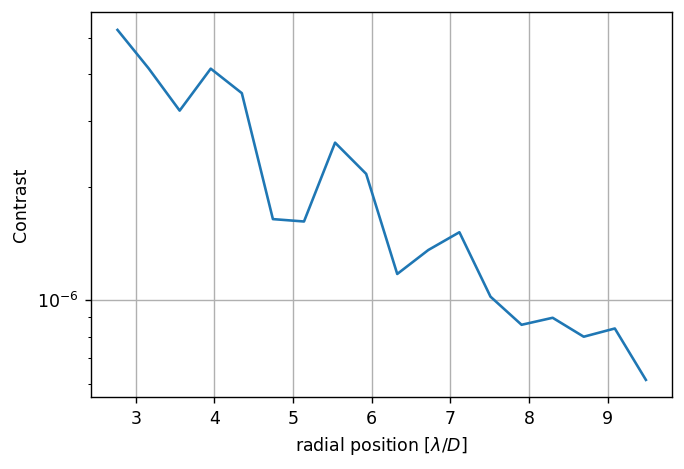

I-EFC loop completed in 34.899s.


In [28]:
reg_cond = 1e-3
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_full, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(mode, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.25, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

(1108, 1108) (1108, 3560)
Running I-EFC...
	Closed-loop iteration 1 / 5


(3560,)

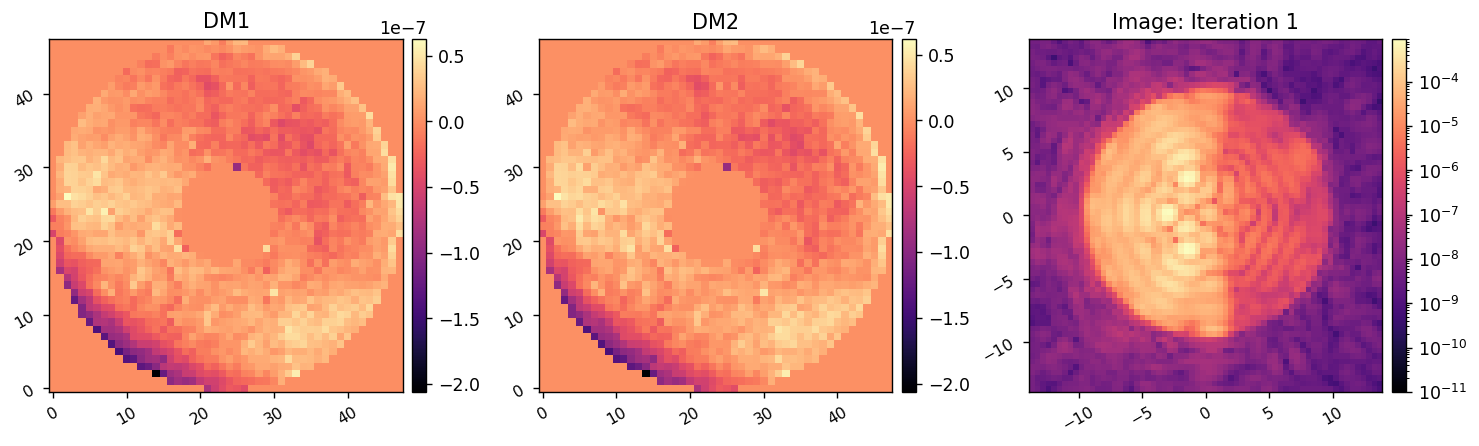

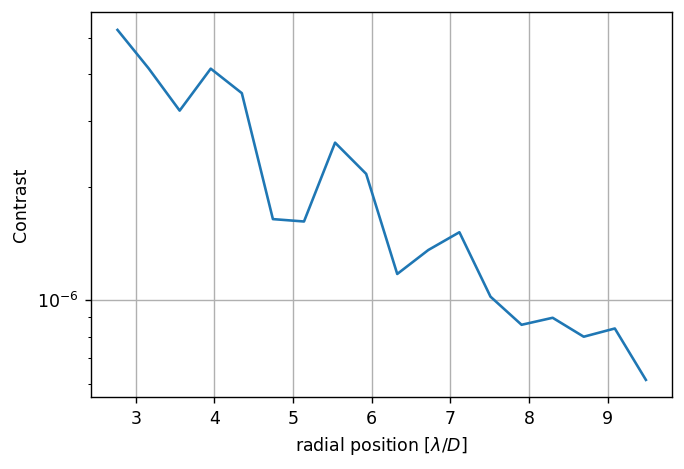

	Closed-loop iteration 2 / 5


(3560,)

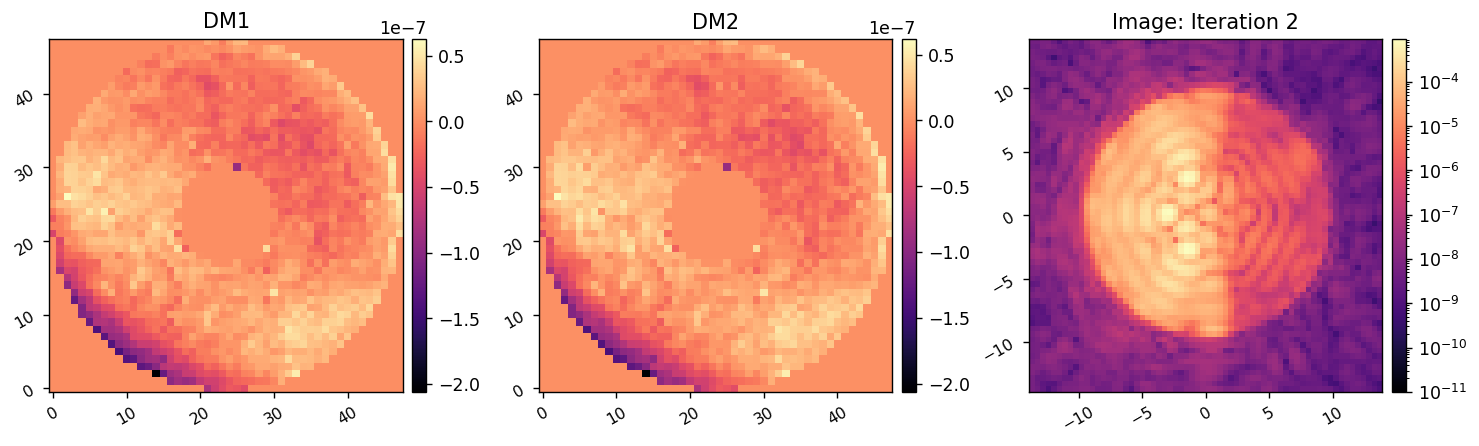

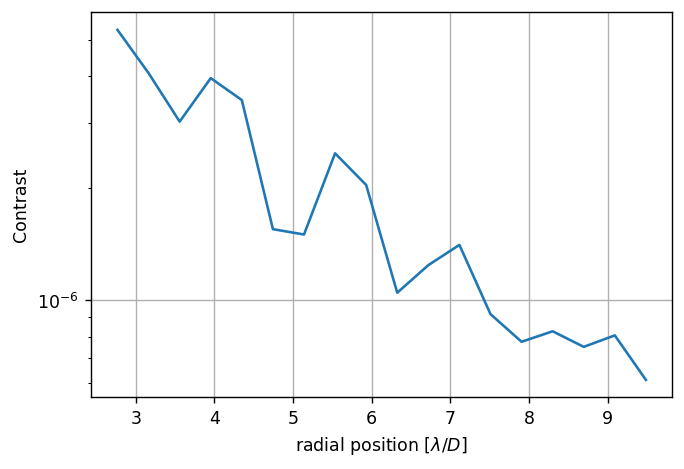

	Closed-loop iteration 3 / 5


(3560,)

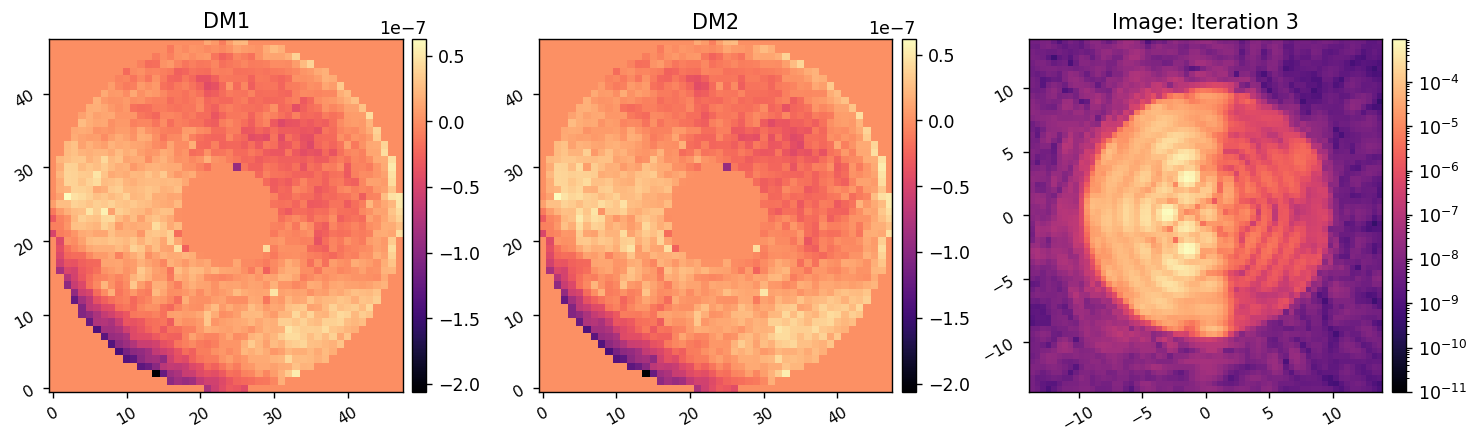

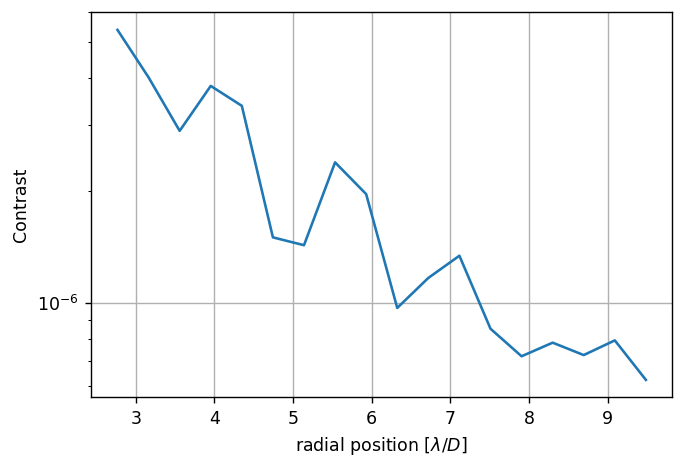

	Closed-loop iteration 4 / 5


(3560,)

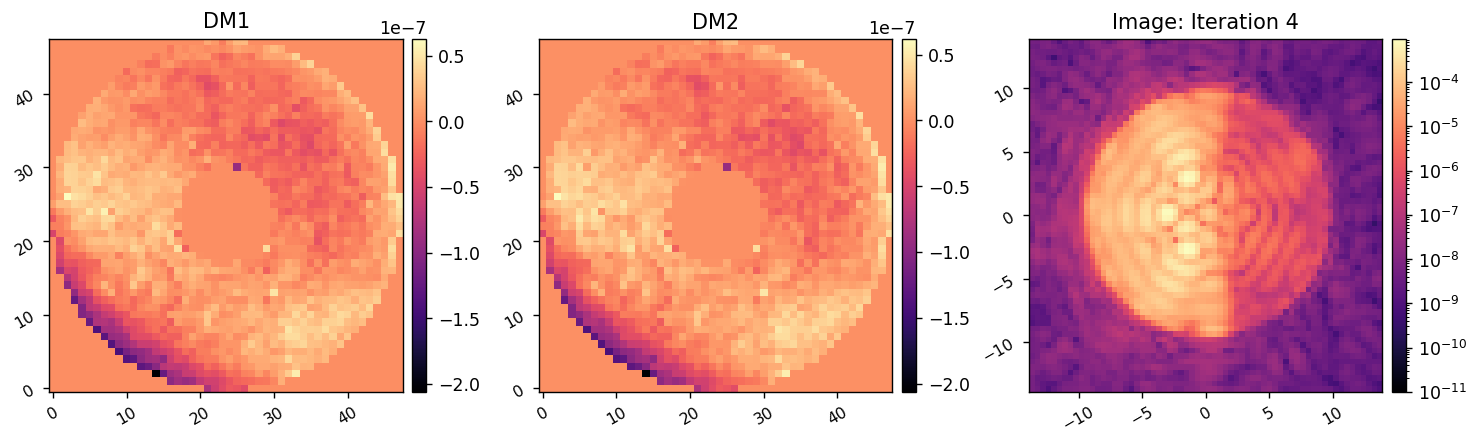

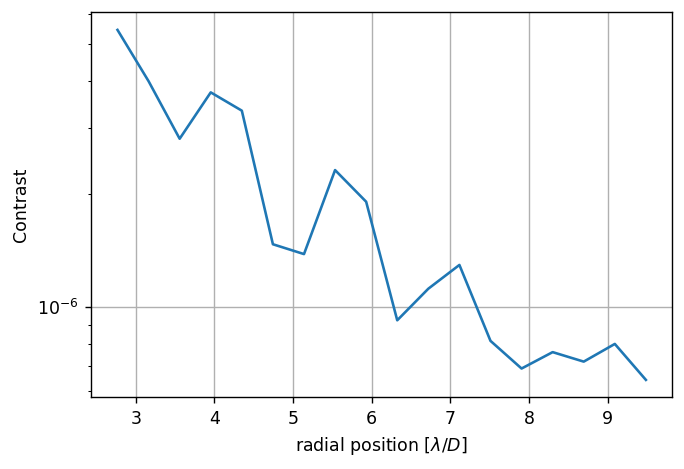

	Closed-loop iteration 5 / 5


(3560,)

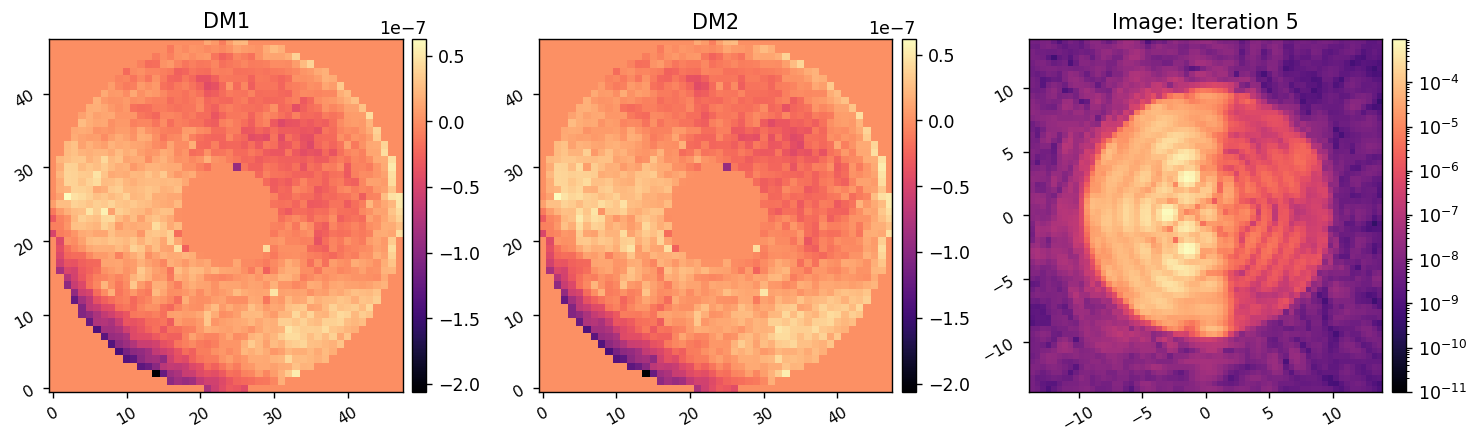

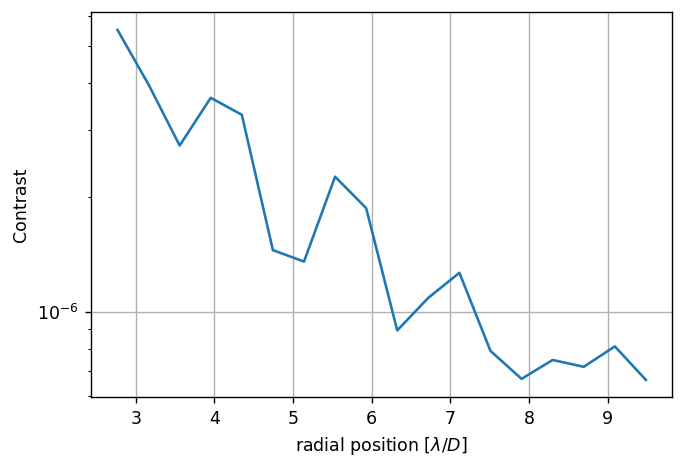

I-EFC loop completed in 35.024s.


In [29]:
reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_full, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(mode, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.25, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )